# Customer Heatmap
##### By Sebastian Rötten

# Index
<a href= '#Regions'>Regions</a> <br>
<a href= '#Data'>0. Data</a> <br>
&nbsp;&nbsp; <a href= '#Sales Dataframe'>0.1 Sales Dataframe</a> <br>
&nbsp;&nbsp; <a href= '#Forecast Dataframe'>0.2 Forecast Dataframe</a> <br>
&nbsp;&nbsp; <a href= '#Activation Dataframe'>0.3 Activation Dataframe</a> <br>
&nbsp;&nbsp;  <a href= '#TAMSAMSOM Dataframe'>0.4 TAMSAMSOM Dataframe</a> <br>
<a href= '#EMEA'>1. EMEA</a> <br>

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
from matplotlib.patches import Rectangle

import functions_eda as eda
import functions_fcst as fcst
import functions_distri as dis
import seaborn as sns
from datetime import datetime, timedelta

#Transfer figure to PPT
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor
import os

from colour import Color
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Define decimal places shown in the notebook
pd.options.display.float_format = '{:,.0f}'.format

# Display the whole content of the data frame
pd.set_option('display.max_columns', None)      # Displays all columns
#pd.set_option('display.max_rows', None)       # Displays all rows

# Ignore warnings while plotting
import warnings
warnings.filterwarnings("ignore")

In [3]:
####  Global colour and graph settings:

#Set Enphase Colour Palette
# Create an array with the colors you want to use
colors  = ['#EA6100','#439E58','#FFD02C','#3B999E','#F45270','#2C436F','#DE2100']

# 2 colors:
colors2 = ['#DE2100','#439E58']
blues = ['#3B999E','#2c436f']
orangeteal = ['#3B999E','#EA6100']
reds = ['#DE2100','#EA6100']
orange = '#EA6100'

# 
sunrise3 = ['#FCB571','#F49787','#2C436F']
sunrise7 = ['#fcb571', '#d9a271', '#b78f70', '#947c70', '#716970', '#4f566f', '#2c436f']
brand6 = ['#fcb571','#faaf7e','#f9a98b','#f7a399','#f69da6','#f497b3']

# Set your custom color palette
sunrise = sns.set_palette(sns.color_palette(sunrise7))
enphase = sns.set_palette(sns.color_palette(orangeteal))

# Transparent Visualisations:
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  # red   with alpha = 100%
})

In [4]:
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  # red   with alpha = 100%
})

In [5]:
Today = pd.Timestamp.today()
CurrWW = pd.Timestamp.today().strftime('%y-%W')
LastWW = (pd.Timestamp.today()- timedelta(days=7)).strftime('%y-%W')
Current = '24 Q4'

<a id='Data'></a>
# 0. Data

- As long as we do not have a data warehouse with SQL interface, the datasets are queried across various systems or self-constructed
- We merge different resources on country - level as long as we do not have a key feature (InstallerCustomerKey)
- Forecasts are only available with the new "Indirect Forecasting" template (DE only so far)
    - Live tracking of forecast only for DE so far
    - Forecast template uses cleaned installer names
- TAMSAMSOM: Too many missing values for reliable analysis
    - SAMs do not now on which parent account they should fill in the data (cleanup)

#### Mapping tables

In [6]:
# Enphase Regions:
dfr = pd.read_excel("/Users/sroetten/Python/Data/EnphaseRegions.xlsx")
dfr.columns = dfr.columns.str.replace(' ', '')

In [7]:
# Enphase quarter
dfq = pd.read_excel("/Users/sroetten/Python/Data/EnphaseQuarters_MAIN.xlsx")

In [8]:
# Enerix
enerix = pd.read_excel("/Users/sroetten/Python/Data/Enerix_Mapping.xlsx")

#enerix = enerix[['InstallerName','InstallerName']]
#enerix = enerix.dropna(subset=['ReportedInstallerName'])

In [9]:
# 1k5
K5 = pd.read_excel("/Users/sroetten/Python/Data/1K5_mappings.xlsx")
K5 = K5[['ReportedInstallerName','InstallerName']]
K5 = K5.dropna()

In [10]:
# ProductGroup - own cluster
PRODUCTS = pd.read_excel("/Users/sroetten/Python/Data/ProductFamily.xlsx")
PRODUCTS.columns = PRODUCTS.columns.str.replace(' ', '')
PRODUCTS.rename(columns={'ProductName': 'SKUName'}, inplace=True)
PRODUCTS=PRODUCTS[["SKUName","ProductGroup"]]

In [11]:
#Mapping table AccountManager
AcMFull = pd.read_csv("/Users/sroetten/Python/Data/Activation_full.csv", encoding='iso-8859-1', decimal='.')
AcMFull.columns = AcMFull.columns.str.replace(' ', '')
AcMFull.groupby(["InstallerId", "SFDC:CustomerKey", "SFDC:AccountName", "SFDC:EnphaseWalletShare"], as_index=False)["SiteType"].sum().to_excel("/Users/sroetten/Python/Data/Activation_map.xlsx",encoding='utf-8-sig',index=False)

In [12]:
AcMNames = AcMFull[['InstallerName', 'Installer_X', "SFDC:CustomerKey", 'SFDC:AccountName']]

In [13]:
# Activation Database SFDC:InstallerKey
AcM = pd.read_excel("/Users/sroetten/Python/Data/Activation_map.xlsx")
AcM = AcM[['InstallerId','SFDC:AccountName','SFDC:CustomerKey','SiteType',"SFDC:EnphaseWalletShare"]]
AcM.rename(columns={'InstallerId' : 'InstallerID',
                    'SFDC:CustomerKey' : 'InstallerCustomerKey',
                    "SFDC:EnphaseWalletShare" : 'SoW',
                    "SiteType" : "SiteCount"
                   }, inplace=True)

In [14]:
# PartnerNames
NAMES = pd.read_excel("/Users/sroetten/Python/Data/PartnerNames.xlsx")
NAMES.columns = NAMES.columns.str.replace(' ', '')

In [15]:
#FR Cluster Enlighten Names:

FR_ENLIGHTEN = pd.read_excel("/Users/sroetten/Python/Data/FR_EnlightenCluster.xlsx")
FR_ENLIGHTEN.columns = FR_ENLIGHTEN.columns.str.replace(' ', '')

In [16]:
#ES Cluster Enlighten Names:

IBERIA = pd.read_excel("/Users/sroetten/Python/Data/IBERIACluster.xlsx")
IBERIA.columns = IBERIA.columns.str.replace(' ', '')

In [17]:
ISO_C = pd.read_excel("/Users/sroetten/Python/Data/RepCountryISO.xlsx")

In [18]:
ZIP = pd.read_excel("/Users/sroetten/Python/Data/EURO_Sales_areas.xlsx")
ZIP.columns = ZIP.columns.str.replace(' ', '')


ZIP.rename(columns={'SAM' : 'InstallerAccountOwner'
                   }, inplace=True)

<a id='Sales Dataframe'></a>
# 0.1 Sales Dataframe

The dataframe is exported on demand via salesforce and contains all Sell-Through data for EMEA on Installer Level

### Incorta Data:

In [19]:
INCORTA = pd.read_csv("/Users/sroetten/Python/Data/Global.csv", encoding='utf-8', decimal='.')
INCORTA.columns = INCORTA.columns.str.replace(' ', '')
RAWINC = INCORTA 
INCORTA = INCORTA.query("CHMGeography == 'EMEA' & CHMProductType in ['Microinverter', 'Storage', 'HEMS']")

In [20]:
print('The global data set for all continents except AMER has {0} transactions in the past 2y.'.format(RAWINC.shape[0]))
print('Our EMEA data set (Micro, Storage, HEMS) has {0} transactions.'.format(INCORTA.shape[0]))

The global data set for all continents except AMER has 303956 transactions in the past 2y.
Our EMEA data set (Micro, Storage, HEMS) has 264560 transactions.


CHM Line Status:

In [21]:
INCORTA.CHMLineStatus = INCORTA.CHMLineStatus.fillna('na')
pd.crosstab(INCORTA.CHMLineStatus, INCORTA.CHMInvoiceQuarterYear, values=INCORTA.CHMReportedQuantity, aggfunc='count', margins=True, margins_name="Total").fillna('0')

CHMInvoiceQuarterYear,2023-Q1,2023-Q2,2023-Q3,2023-Q4,2024-Q1,2024-Q2,2024-Q3,2024-Q4,2025-Q1,2025-Q2,2025-Q3,2025-Q4,Total
CHMLineStatus,,,,,,,,,,,,,
DELETED,0,0,0,0,185,16,28,21,11,20,15,2,298
FAILED,0,0,0,0,"4,852","19,714","12,710","3,624",0,0,0,0,40900
PROCESSED,0,0,0,0,"5,804","21,110","10,251","3,434",0,0,0,0,40599
na,"31,433","39,324","40,043","42,087","29,876",0,0,0,0,0,0,0,182763
Total,"31,433","39,324","40,043","42,087","40,717","40,840","22,989","7,079",11,20,15,2,264560


In [22]:
# Customized CHM:

INCORTA.rename(columns={
 'CHMPartnerNameOracle': 'PartnerName',
 'CHMDistributorCustomerKey':'PartnerCustomerKey',
 'CHMGeography':'PartnerRegion',  
 'CHMPartnerCountry':'PartnerCountry',   
 'CHMReportedInstallerCustomerName': 'ReportedInstallerName',
 'CHMInstallerName':'InstallerName',    
 'CHMReportedInstallerCountry': 'ReportedInstallerCountry',
 'CHMEnphaseInstallerCountry':'InstallerCountry',    
 'CHMInstallerCustomerKey':'InstallerCustomerKey',
 'CHMInstallerAccountOwner': 'InstallerAccountOwner',
 'CHMInstallerPrimaryAccountManager':'AccountManager',
 'CHMReportedInstallerStreetAddress': 'ReportedInstallerStreet1',
 'CHMReportedInstallerCity': 'ReportedInstallerCity',
 'CHMReportedInstallerState': 'ReportedInstallerState',    
# 'CHMReportedZipCode',
 'CHMReportedInstallerZipCode':'ReportedInstallerPostalCode',
 'CHMLineId': 'TransactionNumber',
# 'CHMBatchId',
# 'CHMSourceDb',
# 'CHMLineStatus',
# 'CHMInternalLineStatus',
 'CHMReportedInvoiceDate': 'InvoiceDate',
 'CHMInvoiceWeekDate': 'InvoiceWeekDate',
#                     'CHMInvoiceQuarterYear',
# 'CHMInvoiceQuarterYear',
 'CHMReportedInvoiceNumber': 'PartnerInvoiceNumber',
# 'CHMReportedInvoiceLineNumber',
 'CHMProductType': 'ProductType',
 'CHMProductFamily': 'ProductFamily',
 'CHMReportedPartNumber': 'ReportedProductName',
 'CHMPartNumber':'ProductName',
 'CHMProductDescription': 'ProductDescription',
 'CHMReportedQuantity':'QuantitySold',
#  'ListPrice',
#  'CHMReportedUom',
#  'CHMUom',
  'CHMReportedSpaNumber':'SpaNumber',
#  'CHMSpaNumber',
#  'CHMCreatedBy',
#  'CHMCreationDate',
#  'CHMLastUpdatedBy',
#  'CHMLastUpdatedDate',
#  'CHMFileRecordId',
 'CHMR2rFlag': 'ReporterToReporter'
                      }, inplace=True)   

In [23]:
INCORTA = INCORTA[['TransactionNumber','InvoiceWeekDate','InvoiceDate','PartnerRegion','PartnerCountry','PartnerName',
   'PartnerCustomerKey','QuantitySold','ProductType','ProductFamily','ProductName','ReportedProductName',
   'ProductDescription','ReportedInstallerName','InstallerName','InstallerCustomerKey','InstallerAccountOwner',
   'ReportedInstallerState', 'InstallerCountry','ReportedInstallerCountry', 'ReportedInstallerPostalCode',
   'ReportedInstallerStreet1','ReportedInstallerCity','PartnerInvoiceNumber','ReporterToReporter','SpaNumber','AccountManager']]

In [24]:
eda.missing_values_table(INCORTA)

The selected dataframe has 27 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
AccountManager,239812,91
SpaNumber,192219,73
ReportedInstallerStreet1,155659,59
PartnerInvoiceNumber,77262,29
ReportedInstallerCity,44469,17
PartnerCustomerKey,40193,15
ProductDescription,39509,15
InstallerName,34180,13
InstallerAccountOwner,34180,13
ReportedInstallerState,33956,13


In [25]:
#df = INCORTA.query("InstallerCountry == @Country & 'InvoiceDate' >= '3/15/24'").sort_values("InvoiceDate", ascending=False)
# France SystoSolar Transactions are corrected
INCORTA['QuantitySold'] = INCORTA['QuantitySold'].apply(lambda x: x/1000000 if x >99999 else x) # temporary transformation until France KDI Solar Transactions are corrected
INCORTA['ReporterToReporter'] = INCORTA['ReporterToReporter'].apply(lambda x: 1 if x == 'Y' else 0) # temporary transformation until France KDI Solar Transactions are corrected

INCORTA['QuantitySold'] = INCORTA.QuantitySold.astype('int')
INCORTA['InvoiceDate']= pd.to_datetime(INCORTA['InvoiceDate'])
INCORTA['InvoiceWeekDate']= pd.to_datetime(INCORTA['InvoiceWeekDate'])

# # # Calendarly features:
# INCORTA['Month'] = pd.to_datetime(INCORTA.InvoiceDate).dt.strftime('%m')
# INCORTA['WorkWeek'] = pd.to_datetime(INCORTA.InvoiceDate, dayfirst=False).dt.to_period('W').dt.strftime('%y-%W')
# INCORTA['Year'] = pd.to_datetime(INCORTA.InvoiceDate, dayfirst=False).dt.to_period('y').dt.strftime('%y')
# INCORTA['Year_Month'] = INCORTA['Year'] + '-' + INCORTA['Month']

# INCORTA.shape

In [26]:
#df = df.query("InvoiceWeekDate > '2024-03-13' & InvoiceWeekDate <= @Today")
df = INCORTA.query("InvoiceDate <= @Today")
#INCORTA.to_excel("EMEA/EMEA_Incorta.xlsx",encoding='utf-8-sig',index=False)

#### SFDC Data:

In [27]:
print('Our INCORTA data set has {0} observations.'.format(INCORTA.shape[0]))
print('INCORTAs latest invoice date is {0}.'.format(INCORTA.InvoiceDate.iloc[-1]))
print('INCORTAs earliest invoice date is {0}.'.format(INCORTA.InvoiceDate.iloc[0]))

Our INCORTA data set has 264560 observations.
INCORTAs latest invoice date is 2024-10-28 00:00:00.
INCORTAs earliest invoice date is 2023-01-03 00:00:00.


#### Load historic POS

In [28]:
df21 = pd.read_csv("EMEA21.csv", encoding='iso-8859-1', decimal='.')
df21.columns = df21.columns.str.replace(' ', '')

df21['SpaNumber'] = 0
df21['AccountManager'] = 0

df = df.append(df21)

In [29]:
df22 = pd.read_csv("EMEA22.csv", encoding='iso-8859-1', decimal='.')
df22.columns = df22.columns.str.replace(' ', '')

df22['SpaNumber'] = 0
df22['AccountManager'] = 0

df = df.append(df22)

In [30]:
print('Our original data set has {0} observations.'.format(df.shape[0]))
print('The earliest order date is {0}.'.format(df.InvoiceDate.iloc[-1]))
print('The latest order date is {0}.'.format(df.InvoiceDate.iloc[0]))
print('The current workweek is {0}.'.format(CurrWW))

Our original data set has 374105 observations.
The earliest order date is 1/1/2022.
The latest order date is 2023-01-03 00:00:00.
The current workweek is 24-45.


#### Load DACH missing transactions from Sonepar / Direct Installers

In [31]:
Missing = pd.read_excel("/Users/sroetten/Python/Data/EOQ_MissingTransactions.xlsx")
Missing.columns = Missing.columns.str.replace(' ', '')

Missing['InvoiceDate'] = pd.to_datetime(Missing.InvoiceDate, dayfirst=True)

df = df.append(Missing)

pd.crosstab(Missing.InstallerName, Missing.InvoiceWeekDate.dt.strftime('%y-%m'), values=Missing.QuantitySold, aggfunc='sum', margins=True, margins_name="Total").fillna('0').sort_values("Total", ascending=False).head(20)

InvoiceWeekDate,23-04,23-05,23-06,23-07,23-09,23-12,24-01,24-02,24-03,24-04,24-05,24-06,24-07,Total
InstallerName,,,,,,,,,,,,,,
Total,"1,551","2,875",227,"2,423","1,153","3,274","12,111","1,127","1,325","2,594","1,189",164,208,30221
Sonepar,"1,551","2,875",227,"2,423","1,153","3,274",111,"1,127","1,325","2,594","1,189",164,208,18221
Lichtblick (Direct),0,0,0,0,0,0,"12,000",0,0,0,0,0,0,12000


#### Feature Engineering 

We create features for calendar Weeks, Years, Months, Quarters, QuantitySold_K units and KWhr for relevant storage prodcuts.

Eligible Products are:

3.5 KWhr: 'B03-T01-INT00-1-2' , 'B03-T01-INT00-1', '890-00023', 'ENCHARGE-3T-1P-INT' <br/>
5 KWhr: 'IQ BATTERY-5P-1P-INT' <br/>
10.5KWhr: 'ENCHARGE-10T-1P-INT'

In [32]:
df['Month'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%m')

# #Calendarly features:
df['Month'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%m')
df['WorkWeek'] = pd.to_datetime(df.InvoiceDate, dayfirst=False).dt.to_period('W').dt.strftime('%y-%W')
df['Year'] = pd.to_datetime(df.InvoiceDate, dayfirst=False).dt.to_period('y').dt.strftime('%y')
df['Year_Month'] = df['Year'] + '-' + df['Month']

#Enphase Quarters
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
df = df.merge(dfq[['Day','InvoiceDate','Week','Quarter']], on='InvoiceDate', how='left')

#Enphase formats
df['InstallerName'] = df['InstallerName'].astype('str')
df['ReportedInstallerName'] = df['ReportedInstallerName'].astype('str')


#FillNaN:
df['SpaNumber'] = df.SpaNumber.fillna(0)
df['AccountManager'] = df.AccountManager.fillna(0)


# Quantities in k Units:
df['QuantitySold_k'] = df['QuantitySold']/1000

# Storage Calulations
df['KWhr'] = df['ProductName'].apply(lambda x: 3.5 if x=='B03-T01-INT00-1-2' 
                                                   or x=='B03-T01-INT00-1' 
                                                   or x=='890-00023'
                                                   or x=='ENCHARGE-3T-1P-INT' 
                                                   else 0) + df['ProductName'].apply(lambda x:10.5 if x=='ENCHARGE-10T-1P-INT' else 0) + df['ProductName'].apply(lambda x:5 if x=='IQBATTERY-5P-1P-INT' or x== 'B05-T02-INT00-1-2' else 0)
df['KWhr'] = df['KWhr'] * df['QuantitySold']
df['MWhr'] = df['KWhr'] / 1000

In [33]:
#dfstor.query("InstallerCountry == 'DE' ").tail(50)

## Temporary replacements / conversion:

In [34]:
df = df.merge(enerix, on='ReportedInstallerName', how = 'left')

In [35]:
df['PartnerCountry'] = df.PartnerCountry.fillna('NaN')

all partners with missing country (not filled in yet:)

In [36]:
df.query("PartnerCountry == 'NaN'").groupby(['PartnerName'], as_index=False)["InstallerName"].count()

,PartnerName,InstallerName
0,KRANNICH SOLAR GMBH & CO.KG,450
1,LIBRA ENERGY BV,1160
2,NATEC SUNERGY BV,3127


In [37]:
# # 03/13/24:
df.loc[df.PartnerName=='MAXEON SOLAR TECHNOLOGIES, PTE. LTD', 'PartnerCountry'] = 'DE'

# # 11/03/23:
df.loc[df.PartnerName=='KRANNICH SOLAR GMBH & CO.KG', 'PartnerCountry'] = 'DE'
df.loc[df.PartnerName=='NATEC SUNERGY BV', 'PartnerCountry'] = 'NL'
df.loc[df.PartnerName=='LIBRA ENERGY BV', 'PartnerCountry'] = 'NL'
# df.loc[df.PartnerName=='ESTG', 'PartnerCountry'] = 'NL'
# df.loc[df.PartnerName=='CARBOMAT GROUP', 'PartnerCountry'] = 'BE'
# df.loc[df.PartnerName=='CORAB SPOLKA AKCYJNA', 'PartnerCountry'] = 'PL'
# df.loc[df.PartnerName=='GREENSUN SRL', 'PartnerCountry'] = 'IT'
# df.loc[df.PartnerName=='GROUPE SOLUTION ENERGIE INTEGRATION', 'PartnerCountry'] = 'FR'
# df.loc[df.PartnerName=='IBC SOLAR AG', 'PartnerCountry'] = 'DE'
# df.loc[df.PartnerName=='IBC SOLAR BV', 'PartnerCountry'] = 'NL'
# df.loc[df.PartnerName=='NOUVELLES ENERGIES DISTRIBUTION', 'PartnerCountry'] = 'FR'
# df.loc[df.PartnerName=='NW TECHNOLOGY GMBH', 'PartnerCountry'] = 'DE'
# df.loc[df.PartnerName=='PROPLAST Sp. z o.o.', 'PartnerCountry'] = 'PL'
# df.loc[df.PartnerName=='REXEL NEDERLAND BV', 'PartnerCountry'] = 'NL'
# df.loc[df.PartnerName=='SEN SOLARE ENERGIESYSTEME NORD VERTRIEBSGESELLSCHAFT MBH', 'PartnerCountry'] = 'DE'
# df.loc[df.PartnerName=='SFE SOLAR LOGISITC SL', 'PartnerCountry'] = 'ES'
# df.loc[df.PartnerName=='TECHNISCHE UNIE B.V.', 'PartnerCountry'] = 'NL'

# # 11/10/23:
# df.loc[df.PartnerName=='SOLEXIS SA', 'PartnerCountry'] = 'CH'
# df.loc[df.PartnerName=='TECHNOSOLAR SA', 'PartnerCountry'] = 'CH'
# df.loc[df.PartnerName=='GRID PARITY CONCEPTS', 'PartnerCountry'] = 'BE'

# # 12/18/23
# df.loc[df.PartnerName=='4BLUE', 'PartnerCountry'] = 'NL'
# df.loc[df.PartnerName=='ALASKA ENERGIES', 'PartnerCountry'] = 'FR'
# df.loc[df.PartnerName=='AMARA SOLAR ITALIA SRL', 'PartnerCountry'] = 'IT'
# df.loc[df.PartnerName=='AMARA SOLAR RENOVABLES, S.L', 'PartnerCountry'] = 'ES'
# df.loc[df.PartnerName=='APPROSUD ENVIRONNEMENT', 'PartnerCountry'] = 'FR'
# df.loc[df.PartnerName=='BAYWA R.E. SOLAR ENERGY SYSTEMS GMBH', 'PartnerCountry'] = 'DE'
# df.loc[df.PartnerName=='BAYWA R.E. SOLAR SYSTEMS S.A R.L.', 'PartnerCountry'] = 'LU'
# df.loc[df.PartnerName=='BAYWA R.E. SOLAR SYSTEMS S.A.S', 'PartnerCountry'] = 'FR'
# df.loc[df.PartnerName=='BAYWA R.E. SOLAR SYSTEMS SLU', 'PartnerCountry'] = 'ES'
# df.loc[df.PartnerName=='BET SOLAR SL', 'PartnerCountry'] = 'ES'
# df.loc[df.PartnerName=='CEBEO, NV', 'PartnerCountry'] = 'BE'
# df.loc[df.PartnerName=='ELEKTRA, S.A.', 'PartnerCountry'] = 'ES'
# df.loc[df.PartnerName=='ENERGY3000 SOLAR GMBH', 'PartnerCountry'] = 'AT'
# df.loc[df.PartnerName=='HYDRO-SOLAR S.A.M', 'PartnerCountry'] = 'MC'
# df.loc[df.PartnerName=='MIDSUMMER ENERGY LTD', 'PartnerCountry'] = 'GB'
# df.loc[df.PartnerName=='NAVETTO BV', 'PartnerCountry'] = 'NL'
# df.loc[df.PartnerName=='PVO INTERNATIONAL B.V.', 'PartnerCountry'] = 'NL'
# df.loc[df.PartnerName=='SEN SOLARE ENERGIESYSTEME', 'PartnerCountry'] = 'DE'
# df.loc[df.PartnerName=='SOLARCLARITY BV', 'PartnerCountry'] = 'NL'
# df.loc[df.PartnerName=='SOLARMARKT', 'PartnerCountry'] = 'CH'
# df.loc[df.PartnerName=='SUNTASTIC.SOLAR HANDELS GMBH', 'PartnerCountry'] = 'AT'
# df.loc[df.PartnerName=='SYSTOSOLAR', 'PartnerCountry'] = 'FR'

All partners with missing country (not filled in yet:)

In [38]:
df.query("PartnerCountry == 'NaN'").groupby(['PartnerName'], as_index=False)["InstallerName"].count()

,PartnerName,InstallerName


In [39]:
# France KDI Solar Transactions are corrected
df['QuantitySold'] = df['QuantitySold'].apply(lambda x: x/1000000 if x >999999 else x)     # temporary transformation until France KDI Solar Transactions are corrected

## Data Cleanup:

#### Cleaned InstallerNames
Missing cleaned InstallerNames are filled with reported InstallerNames

In [40]:
df['InstallerName'] = df['InstallerName'].replace('nan', np.nan)

In [41]:
df['InstallerName_source'] = df['InstallerName']
df['InstallerName'] = df['InstallerName'].fillna(df['ReportedInstallerName'])

# for CEBEO N.V. we need to keep the source names, cause all cleaned are mapped to a single Installer
df.loc[(df['PartnerName'] == 'CEBEO, NV'), 'InstallerName'] = df.ReportedInstallerName

#### Cleaned InstallerNames
Missing cleaned InstallerCountries are filled with reported InstallerCountries

In [42]:
df['InstallerCountry_source'] = df['InstallerCountry']
df['InstallerCountry'] = df['InstallerCountry'].fillna(df['ReportedInstallerCountry'])

In [43]:
df['InstallerName'] = df['InstallerName'].astype('str')

In [44]:
#### Fill missing owners with 'No Owner CHM'

df['InstallerAccountOwner'] = df['InstallerAccountOwner'].fillna('No Owner CHM')

In [45]:
df.InstallerName.replace(list(K5.ReportedInstallerName),list(K5.InstallerName), inplace=True)

#### Select final dataframe:

In [46]:
dffull = df

# after changing to enphase quarters we ensure to only have the last 8 Quarters for our graphs:
# We also drop all R2R transactions:
df = dffull.query("Quarter >'22 Q2' & Quarter <= @Current & ReporterToReporter != 1")
#df_EOQ3 = dffull.query("Quarter >'21 Q3' & Quarter <@Current & ReporterToReporter != 1")

print("We lost {} transactions by dropping R2R sales automatically and sales older than 8 Quarters".format(dffull.shape[0]-df.shape[0]))

#print('EMEA\'s QOQ IC development is a {0}% change.'.format(round(((df_IC.InstallerName.iat[-1]/df_IC.InstallerName.iat[-2])-1)*100, 2)))

We lost 69604 transactions by dropping R2R sales automatically and sales older than 8 Quarters


In [47]:
# replace old ReportedInstallerCountry Cleanup
INCORTA.ReportedInstallerCountry.replace(list(ISO_C.ReportedInstallerCountry),list(ISO_C.InstallerCountry), inplace=True)


postals = ['1033 MP', '1087 JA', '1135 TH', '1271 XL', '1328 MA', '1341 BT', '1353 LX', '1431 CN',
 '1445 SC', '1446 AA', '1446 AR', '1446 WL', '1483 GA', '1645 SX', '1681 PK', '1689 ZX', '1704 SL', '1704 SL', '1721 PS', '1812 RR',
 '1822 BG', '1911 LA', '1951 AX', '1981 EH', '2134 TN', '2134 XJ', '2165 BA', '2222 AG', '2231 NL', '2288 AA', '2288 EK', '2801 BX',
 '3165 AM', '3316 EH', '3526 KV', '3584 BH', '3705 TD', '3833 GT', '3846 CE', '4711 NB', '4823 AL', '4827 GE', '5928 RV', '6031 TW',
 '6176 DG', '6534 AJ', '6826 TN', '6827 DD', '6942 JC', '6971 GX', '7008 AS', '7131 MP', '7131 MP', '7311 HZ', '7942 JS', '7944 RN']

df.InstallerCountry.replace(postals,'NL', inplace=True)

# Sub-Distris: InstallerSell Out: 
We drop the following InstallerNames <br/>
We keep them as PartnerNames, to avoid duplicated SellThrough & get a precise IC: <br/>
FR: Voltaneo, Synexiuym, Mavison, Domos <br/>
DE: Beneke GmbH & Co. KG

In [48]:
df = df.query("InstallerName != ['VOLTANEO', 'Mavisun', 'SYNEXIUM Energy', 'Domos Industries']")#.to_excel("France/VoltaneSynMacDomosdrop.xlsx",encoding='utf-8-sig',index=False)

In [49]:
df = df.query("InstallerName != ['Beneke GmbH & Co. KG']")#.to_excel("France/VoltaneSynMacDomosdrop.xlsx",encoding='utf-8-sig',index=False)

## InstallerKeys clean & count of unique InstallerNames
Full list export: to EMEA/EMEA_CleanedKeys&CountNames.xlsx

In [50]:
dfkeys = df.groupby(["InstallerName_source","InstallerCustomerKey"], as_index=False)["ReportedInstallerName"].nunique()

dfkeys.rename(columns={'InstallerName_source': 'InstallerName',
                       'ReportedInstallerName': 'Count_ReportedNames'
                      }, inplace=True)
dfkeys.InstallerCustomerKey = dfkeys.InstallerCustomerKey.astype(int)
dfkeys.to_excel("EMEA/EMEA_CleanedKeys&CountReportedNames.xlsx",encoding='utf-8-sig',index=False)
dfkeys.sort_values('Count_ReportedNames', ascending = False).head(10)

,InstallerName,InstallerCustomerKey,Count_ReportedNames
1413,CEBEO installer POS,3207633,654
4570,Homeowner POS - France,3571473,63
8181,Solar Crew B.V.,1426211,39
1732,City Electrical Factors,125689,35
2382,EDMUNDSON ELECTRICAL LTD,3867058,32
8349,Solard BV,1831712,30
9842,Yesss Electrique Royan,2257179,29
6237,NRGIE Conseil,1713656,28
9665,Warmteservice Groep B.V.,3069604,23
2329,ECO ENERGIE,112782,22


#### InstallerKeys clean & count of unique InstallerNames
Full list export: to EMEA/EMEA_CleanedKeys&CountNames.xlsx

In [51]:
dfkeys.merge(AcM, on ='InstallerCustomerKey', how='left').to_excel("RankingsEMEA/EMEA_Cleanup/CleanedKeys&CountReportedNames&Enlighten.xlsx",encoding='utf-8-sig',index=False)

In [52]:
dfraw = df.groupby(['ReportedInstallerName','ReportedInstallerCountry'], as_index=False)["InstallerName"].count()
dfuncleaned = df.groupby(['ReportedInstallerName','InstallerName_source','InstallerCustomerKey','InstallerCountry', 'InstallerAccountOwner'], as_index=False)["PartnerName"].nunique()
dfuncleaned = dfraw.merge(dfuncleaned, on ='ReportedInstallerName', how='left')
dfuncleaned.InstallerCustomerKey = dfuncleaned.InstallerCustomerKey.fillna(0)
dfuncleaned.InstallerCustomerKey = dfuncleaned.InstallerCustomerKey.astype(int)
dfuncleaned = dfuncleaned.merge(AcM, on ='InstallerCustomerKey', how='left')
dfuncleaned.rename(columns={'InstallerName': 'TransactionCount',
                            'InstallerName_source': 'SFDC:InstallerName',
                            'SFDC:AccountName': 'Enlighten:InstallerName',
                      }, inplace=True)

dfuncleaned[['ReportedInstallerName', 'InstallerAccountOwner','ReportedInstallerCountry','TransactionCount','SFDC:InstallerName','InstallerCustomerKey','InstallerCountry','InstallerID','Enlighten:InstallerName','SoW']]
dfuncleaned.to_excel("RankingsEMEA/EMEA_Cleanup/UncleanedKeys&CountReportedNames.xlsx",encoding='utf-8-sig',index=False)

<a id='Forecast Dataframe'></a>
# Forecast Dataframes

### BOQ Freeze File (R6Q Country Totals)

In [53]:
BOQ = pd.read_excel("/Users/sroetten/Python/Data/BOQ_Freeze.xlsx", sheet_name='Current Overview')
BOQ.columns = BOQ.columns.str.replace(' ', '')
BOQ = BOQ.fillna('0')
PERC = BOQ

PERC['X_GrowthM'] = round(PERC['X_GrowthM']*100,2).astype(str)+'%'
PERC['X_GrowthS'] = round(PERC['X_GrowthS']*100,2).astype(str)+'%'
PERC

,Region,POSSolarKu,StorageMWh,SolarIC,StorageIC,X_InstallerSizeMicro,X_InstallerSizeStorage,X_GrowthM,X_GrowthS,PrevSolarKu,PrevStorageMWh,MicroTAM,StorageTAM
0,EMEA,365,31,4076,1042,90,30,-16.89%,-9.99%,439,35,"2,588","2,428"
1,Netherlands,97,9,1325,203,73,43,0.12%,15.87%,97,8,145,34
2,France,183,4,1450,180,126,21,-19.86%,6.0%,228,4,165,14
3,Germany,35,10,325,303,108,32,-32.57%,-30.29%,52,14,700,"1,140"
4,Spain,16,0,175,27,91,11,14.83%,19.76%,14,0,90,25
5,UK,22,7,200,60,112,112,40.52%,54.56%,16,4,120,166
6,Belgium,10,1,170,42,59,29,36.13%,15.33%,7,1,37,0
7,Italy,4,1,75,19,47,34,2.16%,-24.42%,3,1,325,459
8,Austria,2,0,45,26,33,8,-24.01%,-52.77%,2,0,126,0
9,Poland,0,0,20,3,25,0,33.69%,-100.0%,0,0,213,100


In [54]:
##################################################################################################################################
###########################################     BOQ R6Q Forecast Data     ########################################################
##################################################################################################################################
BOQ = pd.read_excel("/Users/sroetten/Python/Data/BOQ_Freeze.xlsx", sheet_name='Current Overview')
BOQ.columns = BOQ.columns.str.replace(' ', '')
BOQ.fillna('0')
BOQ.rename(columns={'Region': 'InstallerCountry'}, inplace=True)
pd.options.display.float_format = '{:,.0f}'.format

Region = list(BOQ.InstallerCountry)

BOQ.InstallerCountry.replace(Region,
                             ['EMEA','NL', 'FR', 'DE', 'ES', 'GB', 'BE', 'IT', 'AT', 'PL', 'CH', 'PT', 'HU', 'LU', 'IR', 'DK', 'SE', 'NO', 'FI', 'RO', 'GR', 'ZA','ROE'], inplace=True)

##################################################################################################################################
###########################################     EOQ R6Q Forecast Data     ########################################################
##################################################################################################################################

EOQ = pd.read_excel("/Users/sroetten/Python/Data/EOQ_Freeze.xlsx", sheet_name='Current Overview')
EOQ.columns = EOQ.columns.str.replace(' ', '')
EOQ.fillna('0')
EOQ.rename(columns={'Region': 'InstallerCountry'}, inplace=True)
pd.options.display.float_format = '{:,.0f}'.format

Region = list(EOQ.InstallerCountry)

EOQ.InstallerCountry.replace(Region,
                             ['EMEA','NL', 'FR', 'DE', 'ES', 'GB', 'BE', 'IT', 'AT', 'PL', 'CH', 'PT', 'HU', 'LU', 'IR', 'DK', 'SE', 'NO', 'FI', 'RO', 'GR', 'ZA','ROE'], inplace=True)

In [55]:
##################################################################################################################################
#########################################   BOQ Indirect Forecast Data    ########################################################
##################################################################################################################################

dff = pd.read_excel("/Users/sroetten/Python/Data/IndirectForecast_BOQ4.xlsx", header=2, sheet_name='Euro R6Q Basedata')

dff['Total'] = dff.iloc[:,16:22].sum(axis=1)
dff = dff[dff.Total != 0]
dff.columns = dff.columns.str.replace(' ', '')

# replace old PartnerNames
dff.PartnerName.replace(list(NAMES.PartnerNameOld),list(NAMES.PartnerName), inplace=True)

# # Add/Substract compensation amounts from BOQ forecast
# COMP = pd.read_excel("/Users/sroetten/Python/Data/COMP_BOQ1.xlsx", header=2, sheet_name='Euro R6Q Basedata')
# COMP['Total'] = dff.iloc[:,15:21].sum(axis=1)
# COMP = COMP[COMP.Total != 0]
# COMP.columns = COMP.columns.str.replace(' ', '')
# dff = dff.append(COMP)

# Fill NA with 0
dff.iloc[:,17:23] = dff.iloc[:,17:23].fillna('0')
dff['24_Q4'] = pd.to_numeric(dff['24_Q4'], errors='coerce', downcast= 'integer')
dff['25_Q1'] = pd.to_numeric(dff['25_Q1'], errors='coerce', downcast= 'integer')
dff['25_Q2'] = pd.to_numeric(dff['25_Q2'], errors='coerce', downcast= 'integer')
dff['25_Q3'] = pd.to_numeric(dff['25_Q3'], errors='coerce', downcast= 'integer')
dff['25_Q4'] = pd.to_numeric(dff['25_Q4'], errors='coerce', downcast= 'integer')
dff['26_Q1'] = pd.to_numeric(dff['26_Q1'], errors='coerce', downcast= 'integer')

#Rename recent quarter to goal for
dff.rename(columns={'24_Q4': 'Forecast'}, inplace=True)
dff.rename(columns={'Q3_24': 'QuantitySold_template'}, inplace=True)

dff.InstallerName.replace(list(K5.ReportedInstallerName),list(K5.InstallerName), inplace=True)

##################################################################################################################################
###########################################     Storage    #######################################################################
##################################################################################################################################

# Convert all eligible Products to KWhr:
dffkwhr = dff.query("ProductType == 'Storage'")
dffkwhr['KWhr'] = dffkwhr['ProductName'].apply(lambda x: 3.5 if x=='B03-T01-INT00-1-2' 
                                                   or x=='B03-T01-INT00-1' 
                                                   or x=='890-00023'
                                                   or x=='ENCHARGE-3T-1P-INT' 
                                                   else 0) + dffkwhr['ProductName'].apply(lambda x:10.5 if x=='ENCHARGE-10T-1P-INT' else 0)

dffkwhr['Forecast'] = dffkwhr['Forecast'] * dffkwhr['KWhr']
dffkwhr['25_Q1'] = dffkwhr['25_Q1'] * dffkwhr['KWhr']
dffkwhr['25_Q2'] = dffkwhr['25_Q2'] * dffkwhr['KWhr']
dffkwhr['25_Q3'] = dffkwhr['25_Q3'] * dffkwhr['KWhr']
dffkwhr['25_Q4'] = dffkwhr['25_Q4'] * dffkwhr['KWhr']
dffkwhr['26_Q1'] = dffkwhr['26_Q1'] * dffkwhr['KWhr']


#Rename recent quarter to goal for
dffkwhr.iloc[:,17:] = dffkwhr.iloc[:,17:].fillna('0')

In [56]:
##################################################################################################################################
#########################################   EOQ Indirect Forecast Data    ########################################################
##################################################################################################################################


EOQi = pd.read_excel("/Users/sroetten/Python/Data/IndirectForecast_BOQ4.xlsx", header=2, sheet_name='Euro R6Q Basedata')

#EOQi.drop(columns='Q1_22')

EOQi['Total'] = EOQi.iloc[:,16:22].sum(axis=1)
EOQi = EOQi[EOQi.Total != 0]
EOQi.columns = EOQi.columns.str.replace(' ', '')

# replace old PartnerNames
EOQi.PartnerName.replace(list(NAMES.PartnerNameOld),list(NAMES.PartnerName), inplace=True)

# # Add/Substract compensation amounts from BOQ forecast
# COMP = pd.read_excel("/Users/sroetten/Python/Data/COMP_BOQ1.xlsx", header=2, sheet_name='Euro R6Q Basedata')
# COMP['Total'] = EOQi.iloc[:,15:21].sum(axis=1)
# COMP = COMP[COMP.Total != 0]
# COMP.columns = COMP.columns.str.replace(' ', '')
# EOQi = EOQi.append(COMP)

# Fill NA with 0
EOQi.iloc[:,17:23] = EOQi.iloc[:,17:23].fillna('0')
EOQi['24_Q4'] = pd.to_numeric(EOQi['24_Q4'], errors='coerce', downcast= 'integer')
EOQi['25_Q1'] = pd.to_numeric(EOQi['25_Q1'], errors='coerce', downcast= 'integer')
EOQi['25_Q2'] = pd.to_numeric(EOQi['25_Q2'], errors='coerce', downcast= 'integer')
EOQi['25_Q3'] = pd.to_numeric(EOQi['25_Q3'], errors='coerce', downcast= 'integer')
EOQi['25_Q4'] = pd.to_numeric(EOQi['25_Q4'], errors='coerce', downcast= 'integer')
EOQi['26_Q1'] = pd.to_numeric(EOQi['26_Q1'], errors='coerce', downcast= 'integer')

#Rename recent quarter to goal for
EOQi.rename(columns={'24_Q4': 'Forecast'}, inplace=True)
EOQi.rename(columns={'Q3_24': 'QuantitySold_template'}, inplace=True)

EOQi.InstallerName.replace(list(K5.ReportedInstallerName),list(K5.InstallerName), inplace=True)

##################################################################################################################################
###########################################     Storage    #######################################################################
##################################################################################################################################

# Convert all eligible Products to KWhr:
EOQikwhr = EOQi.query("ProductType == 'Storage'")
EOQikwhr['KWhr'] = EOQikwhr['ProductName'].apply(lambda x: 3.5 if x=='B03-T01-INT00-1-2' 
                                                   or x=='B03-T01-INT00-1' 
                                                   or x=='890-00023'
                                                   or x=='ENCHARGE-3T-1P-INT' 
                                                   else 0) + EOQikwhr['ProductName'].apply(lambda x:10.5 if x=='ENCHARGE-10T-1P-INT' else 0)

EOQikwhr['Forecast'] = EOQikwhr['Forecast'] * EOQikwhr['KWhr']
EOQikwhr['25_Q1'] = EOQikwhr['25_Q1'] * EOQikwhr['KWhr']
EOQikwhr['25_Q2'] = EOQikwhr['25_Q2'] * EOQikwhr['KWhr']
EOQikwhr['25_Q3'] = EOQikwhr['25_Q3'] * EOQikwhr['KWhr']
EOQikwhr['25_Q4'] = EOQikwhr['25_Q4'] * EOQikwhr['KWhr']
EOQikwhr['26_Q1'] = EOQikwhr['26_Q1'] * EOQikwhr['KWhr']

#Rename recent quarter to goal for
EOQikwhr.iloc[:,17:] = EOQikwhr.iloc[:,17:].fillna('0')

In [57]:
dffInstaller = dff.groupby("InstallerName", as_index=False)["Forecast"].sum()
dffInstaller.rename(columns={'Forecast': 'BOQ'}, inplace=True)
EOQInstaller = EOQi.groupby("InstallerName", as_index=False)["Forecast"].sum()
EOQInstaller.rename(columns={'Forecast': 'EOQ'}, inplace=True)

dffInstaller = EOQInstaller.merge(dffInstaller, on='InstallerName', how='left').fillna(0)
dffInstaller["Delta"] = dffInstaller.EOQ - dffInstaller.BOQ

In [58]:
dffInstaller.sort_values("Delta", ascending = True)

,InstallerName,EOQ,BOQ,Delta
0,100% ZONNIG,200,200,0
389,SARL POUDRAY,0,0,0
388,SALTOKI,100,100,0
387,S.E.Belgique,0,0,0
386,Rudon BV,0,0,0
...,...,...,...,...
191,France Habitat Gr,0,0,0
192,France Solar,"1,000","1,000",0
193,Future Power AG,120,120,0
187,Fiegl & Spielberger GmbH,105,105,0


<a id='Activation Dataframe'></a>
# Activation Dataframe

#### Micro Activation:

In [59]:
Eligible = ['Verifying (Stage 3)', 'Ready (Stage 4)', 'Final (Stage 5)']

In [60]:
pd.options.display.float_format = '{:,.0f}'.format

dfA = pd.read_csv("/Users/sroetten/Python/Data/ActivationFirst.csv", encoding='utf-8', decimal='.')
dfH = pd.read_csv("/Users/sroetten/Python/Data/ActivationFirst_hist.csv", encoding='utf-8', decimal='.')
dfA = dfA.append(dfH)

# Renaming Columns:
dfA.columns = dfA.columns.str.replace(' ', '')
dfA.rename(columns={'CountofDeviceSerial#': 'Activations',
                   'ï»¿SiteID' : 'SiteID',
                   'ï»¿"SiteID"': 'SiteID'}, inplace=True)

# Append history
dfA = dfA.query("SiteStage == @Eligible")

# Feature Engineering (FirstInterval):
dfA['Month'] = pd.to_datetime(dfA.FirstIntervalDate, dayfirst=False).dt.to_period('M').dt.strftime('%m').astype(str)
dfA['WorkWeek'] = pd.to_datetime(dfA.FirstIntervalDate, dayfirst=False).dt.to_period('W').dt.strftime('%y-%W')
dfA['Year'] = pd.to_datetime(dfA.FirstIntervalDate, dayfirst=False).dt.to_period('y').dt.strftime('%y')
dfA['Year_Month'] = dfA['Year'] + '-' + dfA['Month']
dfA['InvoiceDate']= pd.to_datetime(dfA.FirstIntervalDate, dayfirst=True)
dfA = dfA.merge(dfq[['Day','InvoiceDate','Week','Quarter']], on='InvoiceDate', how='left')
dfA["SystemSize"] = dfA.Activations * 420 / 1000
dfA.rename(columns={'Installer': 'InstallerName'}, inplace=True)

# Enphase ProductGroups
dfA = dfA.merge(PRODUCTS, on='SKUName', how='left')

dfA['Country'] = dfA.Country.fillna('NaN')
dfA['Region'] = dfA.Region.fillna('NaN')

In [61]:
dfA.InstallerName.replace(list(K5.ReportedInstallerName),list(K5.InstallerName), inplace=True)
dfA.Region.replace('EURO','EMEA', inplace=True)

In [62]:
dfA = dfA.query("Year > '20'")

In [63]:
# Merge SFDC Keys!
#dfA = dfA.merge(AcM, on='InstallerID', how='left')

#### Activation per Country 2024: Absolutes on WorkWeeks:

In [64]:
dfAInstaller = dfA.query("Quarter >'23 Q2'")
pd.crosstab(dfAInstaller.Country, dfAInstaller.WorkWeek, values=dfAInstaller.Activations, aggfunc='sum', margins=True, margins_name="Total").fillna('0').sort_values("Total", ascending=False).head(25)#.to_excel("AdHoc/Global_InstallerActivation.xlsx",encoding='utf-8-sig',index=True)

WorkWeek,23-26,23-27,23-28,23-29,23-30,23-31,23-32,23-33,23-34,23-35,23-36,23-37,23-38,23-39,23-40,23-41,23-42,23-43,23-44,23-45,23-46,23-47,23-48,23-49,23-50,23-51,23-52,24-01,24-02,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12,24-13,24-14,24-15,24-16,24-17,24-18,24-19,24-20,24-21,24-22,24-23,24-24,24-25,24-26,24-27,24-28,24-29,24-30,24-31,24-32,24-33,24-34,24-35,24-36,24-37,24-38,24-39,24-40,24-41,24-42,24-43,24-44,24-45,Total
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Total,"2,125","109,478","106,521","101,963","90,448","71,208","69,175","64,508","76,270","85,861","86,403","88,443","85,281","89,556","81,204","82,491","76,308","76,016","63,552","76,616","73,732","77,252","70,893","72,682","79,131","68,234","17,715","27,557","57,101","56,206","64,999","73,640","65,187","67,705","68,144","69,528","74,321","77,657","79,089","71,600","61,718","75,691","74,885","77,508","64,326","56,356","72,728","64,608","72,843","70,176","69,263","65,589","70,000","65,748","61,719","61,066","53,456","47,716","39,498","31,535","38,378","45,115","45,352","45,825","49,176","44,043","44,000","40,766","40,667","45,449","39,202","7,006",4637208
NL,854,"57,597","60,473","55,724","45,003","33,616","34,084","35,760","39,515","43,596","42,454","41,919","39,235","41,488","37,040","34,684","32,439","30,745","26,076","28,898","26,169","27,172","24,621","24,948","25,720","19,940","4,207","8,869","21,026","17,858","19,994","24,705","21,349","22,397","22,118","24,175","25,596","26,167","27,983","27,258","20,032","26,289","22,785","25,489","23,367","19,711","23,586","18,931","21,494","19,797","17,816","16,257","17,320","14,930","14,721","14,007","10,723","8,129","6,660","7,564","7,978","10,120","9,370","8,331","9,559","7,911","8,457","7,981","7,662","7,930","7,221","1,094",1646694
FR,421,"27,862","23,378","26,369","23,893","18,286","13,786","9,012","13,831","19,191","21,210","22,187","21,729","23,553","23,716","23,766","20,986","20,932","16,365","22,046","23,345","23,235","22,563","22,862","23,739","22,795","6,257","11,672","17,878","19,792","23,369","23,923","21,916","24,138","22,104","22,292","24,235","25,159","27,239","24,466","22,581","25,307","27,667","26,810","20,727","14,604","25,073","24,644","28,753","27,857","28,413","25,785","29,010","28,095","24,851","25,300","23,027","20,091","12,790","7,448","10,802","16,119","18,467","19,032","20,315","16,753","18,156","15,689","16,046","17,543","15,222","2,640",1481115
DE,149,"6,228","6,251","6,050","6,602","5,711","6,022","5,926","6,927","6,338","6,268","6,632","6,702","7,183","4,952","6,704","6,336","7,207","5,291","6,737","6,680","7,687","5,995","4,714","7,357","6,019",758,"1,606","3,662","4,160","6,174","7,777","5,990","6,331","6,919","6,306","6,356","6,396","6,181","5,470","4,563","6,519","6,701","6,979","4,883","5,055","6,830","4,570","5,638","6,390","5,521","5,617","6,039","5,483","5,713","5,135","4,650","4,248","4,817","4,396","4,432","4,538","3,980","3,841","4,187","4,793","2,779","4,010","3,751","4,341","3,682",747,387582
AU,118,"4,442","5,057","4,438","4,253","4,992","6,192","6,218","6,195","6,538","5,765","6,134","6,216","5,578","4,254","5,669","6,303","5,905","6,447","6,562","6,318","6,421","5,686","7,739","8,533","6,882",916,807,"4,319","5,002","4,445","5,537","5,446","4,750","5,960","5,470","5,838","5,407","4,998","4,239","3,364","5,387","5,018","3,964","4,287","4,408","5,150","4,682","4,576","4,071","4,272","4,343","5,085","4,619","4,222","4,118","3,811","4,241","4,999","3,311","3,960","4,281","3,795","4,203","4,084","3,238","3,485","2,988","3,437","4,016","3,567",795,341766
BR,2,"1,500",593,702,578,984,861,923,951,540,643,863,"1,366","1,209",842,521,"1,348","1,200",756,"1,503","1,089","1,007","1,284","2,029","1,942","1,846","1,283",786,"2,218","2,006","1,863","2,622","2,096","1,233","1,951","2,106","2,737","2,839","2,530","1,968","2,723","2,487","2,799","3,793","2,160","3,132","2,483","2,558","2,260","2,932","2,404","3,588","2,151","2,168","1,9

In [65]:
#dfAInstaller = dfA.query("Quarter >'23 Q4' & Region == 'EMEA'")
dfAInstaller = dfA.query("Quarter >'23 Q4' & InstallerCountry == 'DE'")

#pd.crosstab(dfAInstaller.InstallerName, dfAInstaller.WorkWeek, values=dfAInstaller.Activations, aggfunc='sum', margins=True, margins_name="Total").fillna('0').sort_values("Total", ascending=False)#.to_excel("AdHoc/DE_InstallerNames_Activation.xlsx",encoding='utf-8-sig',index=False)

In [66]:
################################
####### KOEN Clusters ##########
################################


dfAInstaller = dfA.query("Quarter >'21 Q2' & Country == 'NL'")

pd.crosstab(dfAInstaller.Activations, dfAInstaller.Quarter, values=dfAInstaller.Activations, aggfunc='sum', margins=True, margins_name="Total").fillna('0').sort_values("Total", ascending=False)

dfAInstaller['SysSize_CT'] = dfAInstaller['Activations'].apply(lambda x: 15 if x<16
                                                   else 0) + dfAInstaller['Activations'].apply(
                                                   lambda x:16 if x>15 else 0)+ dfAInstaller['Activations'].apply(lambda x:29 if x>45 else 0)

In [67]:
#pd.crosstab(dfAInstaller.SysSize_CT, dfAInstaller.Quarter, values=dfAInstaller.Activations, aggfunc='sum', margins=True, margins_name="Total").fillna('0').sort_values("Total", ascending=False)#.to_excel("AdHoc/KOEN_ACT_Cluster_SUM.xlsx",encoding='utf-8-sig',index=False)

In [68]:
dfAInstaller = dfA.query("Quarter >'22 Q4'")
#dfAInstaller = pd.crosstab(dfAInstaller.InstallerCustomerKey, dfAInstaller.Quarter, values=dfAInstaller.Activations, aggfunc='sum').reset_index().fillna(0)
dfAInstaller = pd.crosstab(dfAInstaller.InstallerName, dfAInstaller.Quarter, values=dfAInstaller.Activations, aggfunc='sum', margins=True, margins_name="Total").fillna('0').sort_values("Total", ascending=False)
dfAInstaller.columns = dfAInstaller.columns.str.replace(' ', '')

#all floats to int:
cols = dfAInstaller.select_dtypes(include=['float64','object'])
for col in cols:
    dfAInstaller[col] = dfAInstaller[col].apply(lambda x: int(x) if x == x else "")

AcM.rename(columns={'SFDC:AccountName' : 'InstallerName'}, inplace=True)

dfAInstaller = dfAInstaller.merge(AcM[['InstallerName','InstallerCustomerKey','SiteCount','SoW']], on='InstallerName' , how='left')
dfAInstaller = dfAInstaller[['InstallerName','InstallerCustomerKey','23Q1','23Q2','23Q3','23Q4','24Q1','24Q2','24Q3','24Q4','SoW']]

In [69]:
dfAInstaller

,InstallerName,InstallerCustomerKey,23Q1,23Q2,23Q3,23Q4,24Q1,24Q2,24Q3,24Q4,SoW
0,Total,NaN,1157726,1354670,1093136,896432,828349,865796,608320,211382,NaN
1,Solar Concept BV,"791,366",21504,28340,19175,10600,6501,7031,3594,1074,50% - 90%
2,Penrith Solar Centre - Enphase National Instal...,"435,609",8796,8784,12261,10755,12193,9950,9528,3271,> 90%
3,GLATCHI NANCY (1) - CPT0612718,"2,289,984",8247,9473,9623,10373,9393,10665,8849,3812,> 90%
4,Soly,"114,380",10074,18853,10380,4331,2075,1635,1020,331,> 90%
...,...,...,...,...,...,...,...,...,...,...,...
23779,Solar Haus,NaN,0,1,0,0,0,0,0,0,NaN
23780,Kuijpers,NaN,1,0,0,0,0,0,0,0,NaN
23781,Solar Energy Enterprises,NaN,0,0,0,0,1,0,0,0,NaN
23782,LC Energy,"157,075",0,0,0,0,1,0,0,0,50% - 90%


In [70]:
#### Storage Activation
pd.options.display.float_format = '{:,.1f}'.format
dfS = pd.read_csv("/Users/sroetten/Python/Data/ActivationStorage.csv", encoding='utf-8-sig', decimal='.')
dfSH = pd.read_csv("/Users/sroetten/Python/Data/ActivationStorage_hist.csv", encoding='utf-8-sig', decimal='.')

dfS = dfS.append(dfSH)

dfS.rename(columns={'Installer': 'InstallerName'}, inplace=True)
dfS.columns = dfS.columns.str.replace(' ', '')

dfS = dfS.query("SiteStage == @Eligible")

In [71]:
dfS.InstallerName = dfS.InstallerName.fillna('blank')

In [72]:
# Renaming Columns:
dfS.columns = dfS.columns.str.replace(' ', '')
dfS.rename(columns={'CountofDeviceSerial#': 'Activations',
                    'Country':'InstallerCountry',
                    'Retired?':'Retired'}, inplace=True)

# Feature Engineering:
dfS['CreatedAt'] = pd.to_datetime(dfS.DeviceCreatedAt, dayfirst=True)
dfS['Month'] = pd.to_datetime(dfS.DeviceCreatedAt, dayfirst=True).dt.to_period('M').dt.strftime('%m').astype(str)
dfS['WorkWeek'] = pd.to_datetime(dfS.DeviceCreatedAt, dayfirst=True).dt.to_period('W').dt.strftime('%y-%W')
dfS['Year'] = pd.to_datetime(dfS.DeviceCreatedAt, dayfirst=True).dt.to_period('W').dt.strftime('%y')

dfS['Year_Month'] = dfS['Year'] + '-' + dfS['Month']
dfS['InvoiceDate']= pd.to_datetime(dfS.DeviceCreatedAt, dayfirst=True)
#dfS = dfS.merge(dfq[['Day','InvoiceDate','Week','Quarter']], on='InvoiceDate', how='left')

dfS['Activation'] = dfS['SKUName'].apply(lambda x: 3.5 if x=='B03-T01-INT00-1-2' or x =='unknown'
                                                   or x=='ENCHARGE-3T-1P-INT' 
                                                   else 0) + dfS['SKUName'].apply(
                                                   lambda x:10.5 if x=='ENCHARGE-10T-1P-INT' else 0)+ dfS['SKUName'].apply(
                                                   lambda x:3.36 if x=='B03-A01-US00-1-3' or x == 'B03-T01-US00-1-3' else 0)+ dfS['SKUName'].apply(
                                                   lambda x:5 if x=='B05-T02-INT00-1-2' or x=='IQBATTERY-5P-1P-INT' else 0)
dfS['Activation'] = dfS['Activation']*dfS['Activations']
dfS = dfS.merge(dfr[['InstallerCountry','CountryName','PartnerRegion']], on='InstallerCountry', how='left')
#dfS.drop(["Total"], axis=1, inplace=True)

In [73]:
# Query for Retired = Normal and fill missing values

dfS = dfS.query("Retired == 'No'")
dfS['InstallerName'] = dfS.InstallerName.fillna('(blank)')
dfS['State'] = dfS.State.fillna('(blank)')
dfSt = dfS.groupby(["SiteID","InstallerName","PartnerRegion","InstallerCountry","State"]).agg(
    WorkWeek = ('WorkWeek','min'),
    Year_Month = ('Year_Month', 'min'),
    Activations = ('Activation','sum')
     ).reset_index()

#dfSt.sort_values(['WorkWeek'], ascending = [False])
#dfSt.drop_duplicates(['SiteID'], keep='first',  inplace=True)

In [74]:
# dfSInstaller = dfS.query("Year >'23'")
# dfSInstaller = dfSInstaller.merge(dfq, on='InvoiceDate', how='left')
# dfSInstaller = pd.crosstab(dfSInstaller.InstallerName, dfSInstaller.Quarter, values=dfSInstaller.Activations, aggfunc='sum', margins=True, margins_name="Total").fillna('0').sort_values("Total", ascending=False)
# dfSInstaller.columns = dfSInstaller.columns.str.replace(' ', '')
# #dfSInstaller

In [75]:
dfSt

,SiteID,InstallerName,PartnerRegion,InstallerCountry,State,WorkWeek,Year_Month,Activations
0,37445,Solar Bermuda Ltd,AMER,BM,(blank),21-29,21-07,16.8
1,44363,COZIE,EMEA,BE,(blank),23-50,23-12,3.5
2,58729,Solares,LATAM,MX,QRO,24-24,24-06,20.2
3,78193,Byro,EMEA,IT,AO,24-28,24-07,10.0
4,90991,ESE,EMEA,BE,(blank),23-35,23-08,7.0
...,...,...,...,...,...,...,...,...
38008,5530051,"Iberdrola Clientes Portugal, Unipessoal, Lda",EMEA,PT,(blank),24-45,24-11,3.5
38009,5531047,Evo Solar,APAC,AU,VIC,24-45,24-11,0.0
38010,5531463,1K5° Freiburg,EMEA,DE,BW,24-45,24-11,10.5
38011,5531465,SWM GmbH,EMEA,DE,BY,24-45,24-11,7.0


In [76]:
dfSInstaller = dfSt.query("WorkWeek >'23 36'")
pd.crosstab(dfSInstaller.InstallerCountry, dfSInstaller.WorkWeek, values=dfSInstaller.Activations, aggfunc='sum', margins=True, margins_name="Total").fillna('0').sort_values("Total", ascending=False)#.to_excel("AdHoc/Global_Storage_InstallerActivation.xlsx",encoding='utf-8-sig',index=True)

WorkWeek,23-00,23-01,23-02,23-03,23-04,23-05,23-06,23-07,23-08,23-09,23-10,23-11,23-12,23-13,23-14,23-15,23-16,23-17,23-18,23-19,23-20,23-21,23-22,23-23,23-24,23-25,23-26,23-27,23-28,23-29,23-30,23-31,23-32,23-33,23-34,23-35,23-36,23-37,23-38,23-39,23-40,23-41,23-42,23-43,23-44,23-45,23-46,23-47,23-48,23-49,23-50,23-51,23-52,24-01,24-02,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12,24-13,24-14,24-15,24-16,24-17,24-18,24-19,24-20,24-21,24-22,24-23,24-24,24-25,24-26,24-27,24-28,24-29,24-30,24-31,24-32,24-33,24-34,24-35,24-36,24-37,24-38,24-39,24-40,24-41,24-42,24-43,24-44,24-45,Total
InstallerCountry,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Total,198.7,304.5,780.1,683.5,678.6,947.7,922.3,"1,156.8","1,028.2","1,140.6","1,132.3","1,339.2","1,282.7","1,385.2","1,363.0","1,026.1","1,549.5","1,447.7","1,350.3","2,010.5","1,212.0","2,018.7","1,781.1","1,655.5","2,039.1","2,272.6","2,662.2","2,982.3","2,224.7","2,570.8","2,717.1","2,517.9","2,839.9","2,287.2","2,935.0","2,984.9","2,807.4","3,038.3","2,930.7","3,407.1","2,242.5","2,986.9","3,157.8","2,952.7","2,280.2","2,921.5","2,956.7","3,074.9","2,831.3","2,651.6","3,543.0","3,132.0",569.5,"1,086.3","2,470.4","2,607.2","3,310.9","3,678.0","3,572.4","3,599.5","3,721.5","3,377.0","3,379.4","3,348.7","3,859.2","3,098.0","2,587.1","3,051.5","3,279.0","3,556.4","2,726.9","2,597.0","3,495.6","2,744.0","3,252.0","3,256.0","3,474.8","2,974.7","3,321.7","3,288.0","2,856.5","2,895.0","2,747.9","2,446.5","2,792.0","2,977.1","3,091.0","3,124.0","3,014.6","3,264.5","3,285.5","3,755.0","2,858.0","3,209.5","3,325.5","3,316.2","3,149.0",582.5,"244,315.7"
DE,87.5,273.0,567.0,444.5,525.0,714.0,700.0,798.0,745.5,857.5,759.5,892.5,920.5,"1,092.0","1,032.5",808.5,"1,295.0","1,130.5","1,130.5","1,540.0",959.0,"1,652.0","1,417.5","1,407.0","1,669.5","1,841.0","2,103.5","2,481.5","1,904.0","2,135.0","2,247.0","2,058.0","2,198.0","1,865.5","2,404.5","2,478.0","2,121.0","2,474.5","2,355.5","2,446.5","1,540.0","2,324.0","2,436.0","2,355.5","1,676.5","2,166.5","2,169.9","2,282.0","1,907.5","1,634.5","2,404.5","1,764.0",269.5,546.0,"1,316.0","1,403.5","2,047.4","2,415.0","2,079.0","2,306.5","2,310.0","2,201.5","2,128.0","2,100.0","2,331.0","1,715.0","1,452.5","2,040.5","2,219.0","2,296.0","1,536.5","1,543.5","2,072.0","1,620.5","1,963.5","2,040.5","2,005.5","1,771.0","2,041.6","1,802.5","1,872.5","1,785.0","1,543.5","1,151.5","1,379.0","1,578.5","1,676.5","1,547.0","1,386.0","1,491.0","1,449.0","1,617.0",794.5,"1,249.5","1,358.0","1,414.0","1,148.0",304.5,"157,511.3"
NL,0,0,0,0,0,0,0,17.5,0,0,7.0,14.0,14.0,3.5,3.5,0,3.5,3.5,3.5,31.5,28.0,35.0,14.0,7.0,35.0,54.0,66.5,70.0,38.5,52.5,91.0,42.0,126.0,84.0,28.0,35.0,101.5,77.0,70.0,136.5,143.5,126.0,94.5,115.5,189.0,269.5,192.5,178.5,122.5,217.0,217.0,192.5,31.5,28.0,129.5,213.5,252.0,143.5,203.0,231.0,129.5,269.5,209.9,262.5,325.0,241.5,311.0,283.5,227.5,238.0,357.0,259.0,444.5,301.0,297.5,413.0,510.5,395.5,454.5,567.0,409.5,339.5,430.0,455.0,488.5,529.0,521.0,686.5,581.0,659.0,665.5,674.0,637.0,539.5,556.0,495.0,501.0,83.5,"20,330.9"
FR,0,0,0,0,0,0,0,0,0,0,14.0,17.5,10.5,7.0,42.0,21.0,24.5,45.5,14.0,66.5,56.0,119.0,59.5,45.5,80.5,122.5,182.0,56.0,42.0,115.5,112.0,70.0,42.0,63.0,91.0,119.0,140.0,119.0,147.0,231.0,150.5,196.0,203.0,140.0,126.0,231.0,147.0,192.5,231.0,140.0,129.5,259.0,63.0,56.0,238.0,220.5,147.0,259.0,108.5,171.5,273.0,210.0,185.5,238.0,223.5,293.5,206.5,171.5,220.5,266.0,209.9,140.0,262.5,161.5,268.5,253.5,257.0,185.5,217.0,272.5,87.5,200.5,241.9,205.0,236.5,85.5,117.5,112.0,209.0,170.5,260.0,363.5,246.5,310.5,286.0,277.5,203.0,58.5,"13,871.2"
BE,91.0,31.5,203.0,178.5,122.5,192.5,168.0,280.0,255.5,273.0,269.5,332.5,269.5,217.0,227.5,94.5,150.5,164.5,115.5,147.0,80.5,101.5,185.5,87.5,108.5,108.5,143.5,140.0,126.0,112.0,70.0,119.0,122.5,87.5,119.0,140.0,73.5,70.0,91.0,94.5,112.0,105.0,157.5,91.0,56.0,108.5,161.0,154.0,119.0,115.5,140.0,108.5,21.0,7.0,77.0,101.5,129.5,122.5,154.0,1

<a id='TAMSAMSOM Dataframe'></a>
# TAMSAMSOM Dataframe

In [77]:
TAM = pd.read_csv("/Users/sroetten/Python/Data/TAMSAMSOM.csv", encoding='iso-8859-1', decimal='.')
TAM.columns = TAM.columns.str.replace(' ', '')

TAM.AccountName.replace(list(K5.ReportedInstallerName),list(K5.InstallerName), inplace=True)

#### Missing Values:

- high priority!
- we need to start analyzing on cleaned data

In [78]:
eda.missing_values_table(TAM)

The selected dataframe has 22 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
CommercialStorageTAM(annualMWh),108655,99.7
CommercialPVTAM(annualMW),107673,98.8
EnphaseStorageMarketShare(SOM),107041,98.2
ResidentialStorageTAM(annualMWh),106537,97.8
ResidentialPVTAM(annualMW),101931,93.6
EnphaseWalletShare,101364,93.0
SubTerritory,97707,89.7
Phone,86725,79.6
EnphaseResiPVMarketShare(SOM),70702,64.9
SupportEmail,57261,52.6


In [79]:
ALLTIME = df.groupby(["InstallerName"], as_index=False)["QuantitySold_k"].sum().sort_values("InstallerName", ascending=False)

In [80]:
TAM.rename(columns={'AccountName': 'InstallerName',
                    'AccountOwner': 'InstallerAccountOwner',
                    'ResidentialPVTAM(annualMW)':'PV_TAM',
                    'BillingCountry':'InstallerCountry'
                    }, inplace=True)

df_TAM = TAM.groupby(["InstallerName",'InstallerCountry','InstallerAccountOwner','PV_TAM'], as_index=False)["PV_TAM"].mean().sort_values("PV_TAM", ascending=False)
df_TAM = df_TAM.merge(ALLTIME[['InstallerName','QuantitySold_k']], on='InstallerName', how='left').fillna(0)
df_TAM = df_TAM.merge(TAM[['InstallerName','EnphaseWalletShare']], on='InstallerName', how='left').fillna(0)

df_TAM.drop_duplicates(['InstallerName'], keep='first',  inplace=True)

In [81]:
TAM_c = TAM.groupby(['InstallerCountry'], as_index=False)["PV_TAM"].sum().sort_values("PV_TAM", ascending=False)
TAM_c.merge(BOQ[['InstallerCountry','MicroTAM', 'StorageTAM']], on = 'InstallerCountry', how = 'left')

,InstallerCountry,PV_TAM,MicroTAM,StorageTAM
0,DE,"3,386.4",700.0,"1,140.0"
1,NL,"1,502.5",145.0,34.0
2,AT,878.6,126.0,0.0
3,AU,838.6,NaN,NaN
4,BE,668.7,37.0,0.0
...,...,...,...,...
231,KI,0.0,NaN,NaN
232,KN,0.0,NaN,NaN
233,KP,0.0,NaN,NaN
234,KR,0.0,NaN,NaN


In [82]:
df_TAM.query("InstallerCountry == 'DE'")

,InstallerName,InstallerCountry,InstallerAccountOwner,PV_TAM,QuantitySold_k,EnphaseWalletShare
0,Enpal B.V.,DE,Kai Gehrke,400.0,0.0,0
2,Densys PV5 GmbH,DE,Manfred Schmidt,138.0,5.6,0
4,Energiekonzepte Deutschland GmbH,DE,Kai Gehrke,120.0,31.8,0
6,ZOLAR GmbH,DE,Kai Gehrke,108.0,0.0,0
10,Energieversum GmbH & Co. KG,DE,Vahid Parma,90.0,0.0,0
...,...,...,...,...,...,...
7292,DFH Haus GmbH,DE,Vahid Parma,0.0,0.0,0
7296,SB Elektrotechnik GmbH & Co. KG,DE,Manfred Schmidt,0.0,0.0,0
7332,Elosol e.K.,DE,Martin Binzer,0.0,0.0,0
7337,D. Rieke Elektrotechnik,DE,Vahid Parma,0.0,0.0,0


In [83]:
# df_TAM = df_TAM.groupby(["InstallerName",'EnphaseWalletShare','PV_TAM'], as_index=False)["QuantitySold_k"].sum().sort_values("QuantitySold_k", ascending=False)
# df_TAM = df_TAM.sort_values('PV_TAM', ascending = False)

In [84]:
df_TAM.query("InstallerCountry == 'DE'")

,InstallerName,InstallerCountry,InstallerAccountOwner,PV_TAM,QuantitySold_k,EnphaseWalletShare
0,Enpal B.V.,DE,Kai Gehrke,400.0,0.0,0
2,Densys PV5 GmbH,DE,Manfred Schmidt,138.0,5.6,0
4,Energiekonzepte Deutschland GmbH,DE,Kai Gehrke,120.0,31.8,0
6,ZOLAR GmbH,DE,Kai Gehrke,108.0,0.0,0
10,Energieversum GmbH & Co. KG,DE,Vahid Parma,90.0,0.0,0
...,...,...,...,...,...,...
7292,DFH Haus GmbH,DE,Vahid Parma,0.0,0.0,0
7296,SB Elektrotechnik GmbH & Co. KG,DE,Manfred Schmidt,0.0,0.0,0
7332,Elosol e.K.,DE,Martin Binzer,0.0,0.0,0
7337,D. Rieke Elektrotechnik,DE,Vahid Parma,0.0,0.0,0


<a id='Regions'></a>
## Regions
Bad data quality: <br/>
Different SAMs are working in multiple countries. <br/>
"Boomi FullUser" are unmapped sales in various countries?

#### All Installer Names and Installer Counts:

In [85]:
ALL_IC = df.query("Quarter == @Current").groupby(["InstallerCountry"], as_index=False)["InstallerName"].nunique()
ALL_IC2 = df.query("Quarter == @Current").groupby(["InstallerCountry"], as_index=False)["InstallerName"].nunique()
ALL_IC = ALL_IC.merge(ALL_IC2, on='InstallerCountry', how='left').fillna(0)

ALL_IC.rename(columns={'InstallerName_x': '24_Q3',
                      'InstallerName_y': '24_Q4'}, inplace=True)

<a id='EMEA'></a>
# 1. EMEA

In [86]:
Country = 'EURO'

<a id='EMEA Forecasts'></a>
## 1.1 EMEA Indirect Forecast Overviews

## 1.11 FCSTs Microinverter

#### EOQ Microinverter: Forecast by Country, Owners, Distributors:

In [87]:
pd.options.display.float_format = '{:,.0f}'.format

Countries = list(EOQi.groupby(["InstallerCountry"], as_index=False)["Forecast"].sum().InstallerCountry)

dff_Cm = fcst.Country(EOQi, Countries, 'Microinverter')
dff_Cm.loc[df.index[-1]] = ['EMEA', dff_Cm.Forecast.sum(),  
                                         dff_Cm.Q1_25.sum(), 
                                         dff_Cm.Q2_25.sum(),
                                         dff_Cm.Q3_25.sum(),
                                         dff_Cm.Q4_25.sum(),
                                         dff_Cm.Q1_26.sum()]

dff_Cm.iloc[:,-6:] = dff_Cm.iloc[:,-6:].astype('int')

dff_AOm = fcst.Owners(EOQi, Countries, 'Microinverter')
dff_AOm = dff_AOm.query("Forecast > 0")
dff_AOm.iloc[:,-6:] = dff_AOm.iloc[:,-6:].astype('int')

dff_DISm = fcst.Distri(EOQi, Countries, 'Microinverter')
dff_DISm = dff_DISm.query("Forecast > 0")
dff_DISm.iloc[:,-6:] = dff_DISm.iloc[:,-6:].astype('int')

#eda.display_side_by_side([dff_Cm, dff_AOm, dff_DISm], ['Microinverter Indirect FCST per Country', 'Microinverter Indirect FCST per Owner', 'Microinverter Indirect FCST per Distri'])

BOQ for comparision:

In [88]:
BOQi_AOm = fcst.Owners(dff, Countries, 'Microinverter')
BOQi_AOm = BOQi_AOm.query("Forecast > 0")
BOQi_AOm.iloc[:,-6:] = dff_AOm.iloc[:,-6:].astype('int')

In [89]:
GAP = EOQ[['InstallerCountry', 'POSSolarKu']]
indi = dff_Cm[['InstallerCountry','Forecast']]

GAP = GAP.merge(indi, on='InstallerCountry', how='left').fillna(0)
GAP['Indirect_Forecast'] = GAP['Forecast']/1000
#GAP.rename(columns = {'Forecast':'IndirectForecast'}, inplace=True)
GAP['R6Q_total'] = GAP['POSSolarKu'] 
#GAP = GAP.query("InstallerCountry != 'EURO'")

### EOQ Country:  R6Q Totals vs. Indirect Forecast

If the Country Leader has no personal ambition 100% of the country total must be explained by R6Q


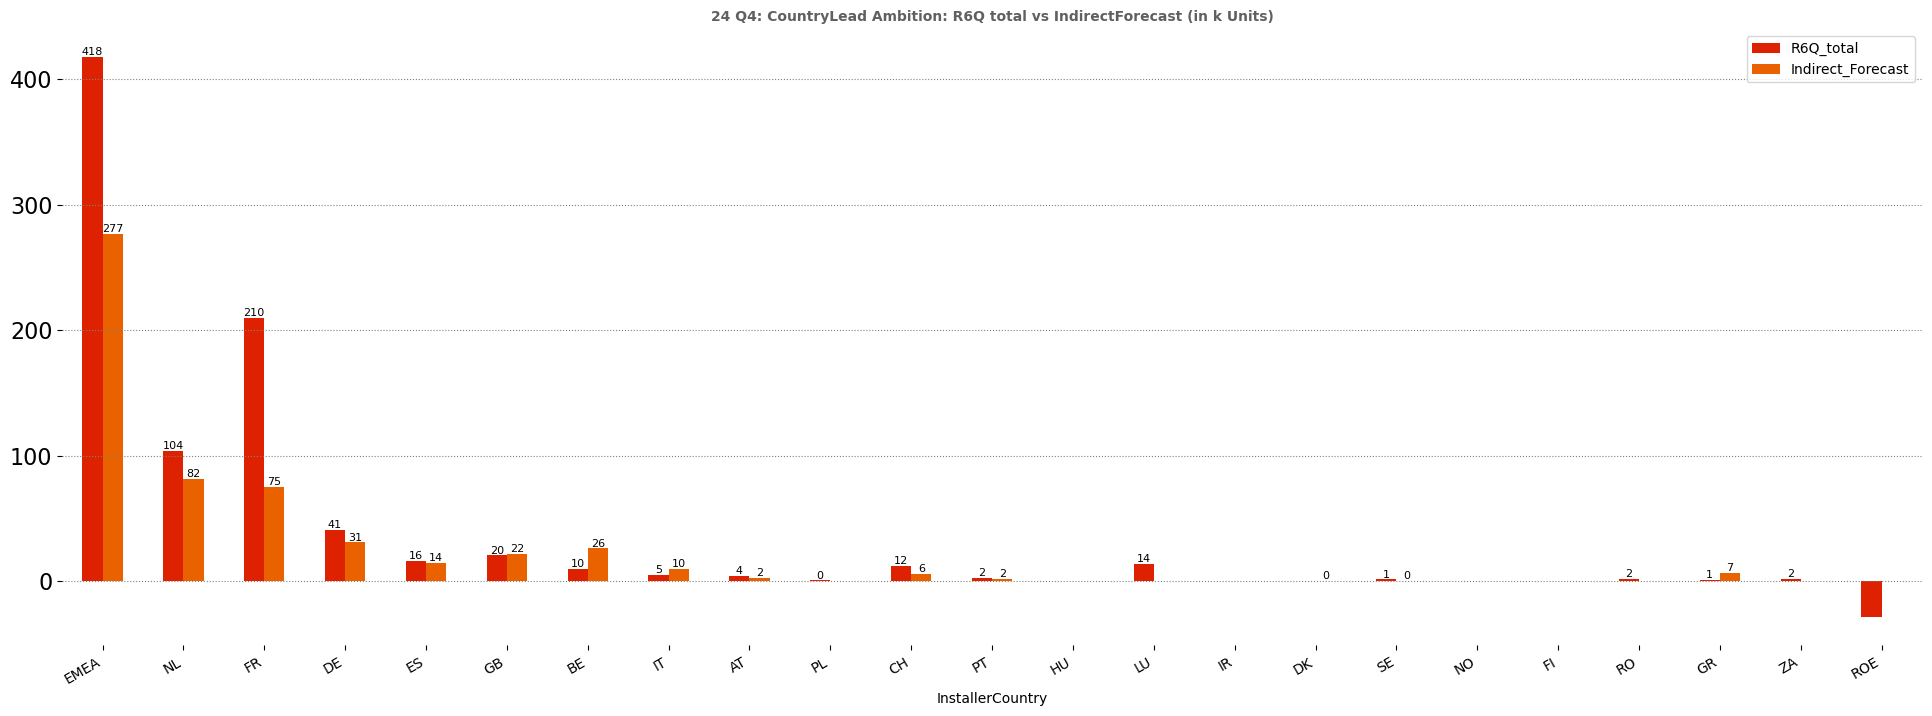

In [90]:
# customize / calculate gaps
eda.X_barchart(GAP, 'InstallerCountry', 'R6Q_total', 'Indirect_Forecast', '24 Q4: CountryLead Ambition: R6Q total vs IndirectForecast (in k Units)', (24,8), reds)

print('If the Country Leader has no personal ambition 100% of the country total must be explained by R6Q')

### Country:  SellThrough vs. Indirect Forecast:

In [91]:
GAP = EOQ[['InstallerCountry', 'POSSolarKu']]
dfC = df.query("Quarter == @Current & ProductType == 'Microinverter'").groupby(["InstallerCountry"], as_index=False)["QuantitySold_k"].sum()
GAP = GAP.merge(dfC, on='InstallerCountry', how='left').fillna(0)
GAP.rename(columns = {'POSSolarKu':'Forecast'}, inplace=True)
GAP = GAP.query("Forecast > 0")
df_C = df.query("ProductType == 'Microinverter'")
GAP.QuantitySold_k.iat[0] = df_C.groupby(["Quarter"], as_index=False)["QuantitySold_k"].sum().QuantitySold_k.iat[-1]

In [92]:
Country = 'EMEA'

By today EMEA met 34.76% of its BOQ forecast.


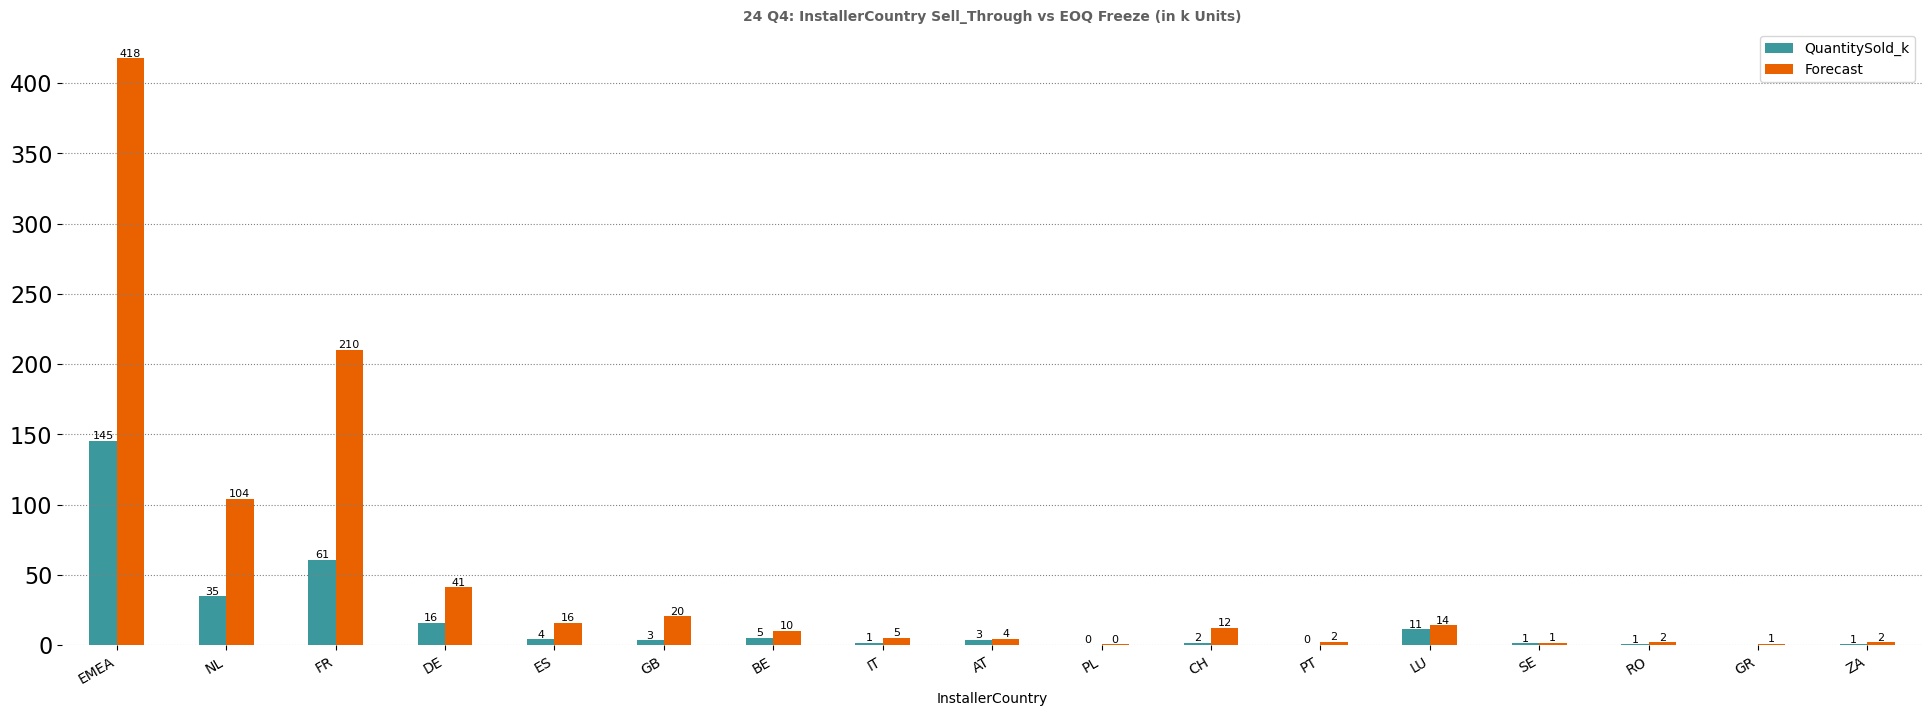

In [93]:
# customize / calculate gaps
eda.X_barchart(GAP, 'InstallerCountry', 'QuantitySold_k', 'Forecast', '24 Q4: InstallerCountry Sell_Through vs EOQ Freeze (in k Units)', (24,8), orangeteal)
print('By today EMEA met {0}% of its BOQ forecast.'.format(round((GAP.query("InstallerCountry == @Country").QuantitySold_k.iat[-1]/GAP.query("InstallerCountry == @Country").Forecast.iat[-1])*100, 2)))

## 1.12 FCSTs Storage

#### BOQ Storage: Forecast by Country, Owners, Distributors:

## 1.13 HEMS FCST

In [94]:
Countries = list(dff.groupby(["InstallerCountry"], as_index=False)["Forecast"].sum().InstallerCountry)

dff_Ch = fcst.Country(dff, Countries, 'HEMS')
dff_Ch = dff_Ch.query("Forecast > 0")
dff_Ch.iloc[:,-6:] = dff_Ch.iloc[:,-6:].astype('int')

dff_AOh = fcst.Owners(dff, Countries, 'HEMS')
dff_AOh = dff_AOh.query("Forecast > 0")
dff_AOh.iloc[:,-6:] = dff_AOh.iloc[:,-6:].astype('int')

dff_DISh = fcst.Distri(dff, Countries, 'HEMS')
dff_DISh = dff_DISh.query("Forecast > 0")
dff_DISh.iloc[:,-6:] = dff_DISh.iloc[:,-6:].astype('int')

<a id='EMEA SPA'></a>
## 1.2 SellThrough via SPA:

#### SPA per Country, SAM, Distri

In [95]:
dfSPA = df.query("SpaNumber != 0 & SpaNumber != '0' & SpaNumber != '00'")

In [96]:
dfSPA = dfSPA[['TransactionNumber', 'SpaNumber', 'PartnerCountry', 'InstallerCountry', 'PartnerName', 'InstallerName','InstallerCustomerKey','InstallerAccountOwner', 'QuantitySold', 'QuantitySold_k', 'Quarter']]

In [97]:
dfSPA = df.query("SpaNumber != 0 & SpaNumber != '0' & SpaNumber != '00'")

SPA = dis.multidim_crosstab(dfSPA, 'InstallerCountry', 'InstallerName')
SPA.iloc[:,-14:] = SPA.iloc[:,-14:].astype('int')

cols = list(SPA.iloc[:,-14:].columns)
SPA = SPA.rename(columns={c: c+'_SPA' for c in SPA.columns if c in cols})

#SPA.to_excel("EMEA/SPA_Sales.xlsx",encoding='utf-8-sig',index=False)
SPACountry = dis.multidim_crosstab(dfSPA, 'PartnerCountry', 'InstallerCountry')
SPACountry.iloc[:,-14:] = SPACountry.iloc[:,-14:].astype('int')
#SPA.to_excel("EMEA/SPA_Sales.xlsx",encoding='utf-8-sig',index=False)
SPAOwner = dis.multidim_crosstab(dfSPA, 'InstallerAccountOwner', 'InstallerCountry')
SPAOwner.iloc[:,-14:] = SPAOwner.iloc[:,-14:].astype('int')
#SPA.to_excel("EMEA/SPA_Sales.xlsx",encoding='utf-8-sig',index=False)

## EMEA Micro Ranking Tables:

Full Tables can be found on the Global CCO SharePoint in RankingsEMEA:  <br/> 
<br/> https://enphase.sharepoint.com/:f:/r/sites/CCOGroup730/Shared%20Documents/Sales%20Review%20Global/RankingsEMEA?csf=1&web=1&e=wLSt33

In [98]:
dfTAM = TAM.groupby(["InstallerName","InstallerAccountOwner"], as_index=False)["PV_TAM"].mean().sort_values('PV_TAM', ascending = False)
dfTAM.drop_duplicates(['InstallerName'], keep='first',  inplace=True)

In [99]:
def Installers(dff, Type):
    dff_p = dff.query("ProductType == @Type")
    dff_p = dff_p.groupby(["InstallerName"]).agg(
         MFCST = ('Forecast','sum'), 
         MFCST_Q1_25 = ('25_Q1','sum'),        
         MFCST_Q2_25 = ('25_Q2','sum'),      
         MFCST_Q3_25 = ('25_Q3','sum'),
         MFCST_Q4_25 = ('25_Q4','sum'),
         MFCST_Q1_26 = ('26_Q1','sum'),
         ).reset_index()
    dff_p.append(dff_p.sum(numeric_only=True), ignore_index=True)
    dff_p = dff_p.replace('NaN','Total')
    #dff_p.style.hide_index()
    return dff_p

In [100]:
dff_i = Installers(dff, 'Microinverter')
dff_i

,InstallerName,MFCST,MFCST_Q1_25,MFCST_Q2_25,MFCST_Q3_25,MFCST_Q4_25,MFCST_Q1_26
0,100% ZONNIG,200,250,500,500,500,500
1,100%ZON,0,0,0,0,0,0
2,1K5° Barcelona,"2,000","3,000","3,000","3,000","3,000","3,000"
3,1K5° Berlin,500,800,"1,000","1,000","1,000","1,000"
4,1K5° Bremen,225,0,0,0,0,0
...,...,...,...,...,...,...,...
542,soNachhaltig GmbH,250,350,500,700,900,900
543,soleil du sud,0,0,0,0,0,0
544,stan falconi,0,0,0,0,0,0
545,thijs,0,0,0,0,0,0


In [101]:
# Indirect Forecast on Installer Level
dfICIN = dis.multidim_crosstab(df, 'InstallerCountry', 'InstallerName')

dfkeys.drop_duplicates(['InstallerName'], keep='first',  inplace=True)

dff_i = Installers(dff, 'Microinverter')

# Merge other DBs
dfICIN = dfICIN.merge(dfAInstaller[['InstallerName','23Q1','23Q2','23Q3','23Q4','24Q1','24Q2','24Q3','24Q4','SoW']], on = 'InstallerName', how='left')
dfICIN = dfICIN.merge(dfkeys, on = 'InstallerName', how='left')
dfICIN = dfICIN.merge(dff_i, on = 'InstallerName', how='left')
dfICIN = dfICIN.merge(dfTAM[['InstallerName','InstallerAccountOwner', 'PV_TAM']], on = 'InstallerName', how='left')
dfICIN = dfICIN.merge(SPA[['InstallerName','Q424_ST_SPA']], on = 'InstallerName', how='left')         #SPA dropped

dfICIN.rename(columns={'23Q1': '23Q1_Activations',
                       '23Q2': '23Q2_Activations',
                       '23Q3': '23Q3_Activations',
                       '23Q4': '23Q4_Activations',
                       '24Q1': '24Q1_Activations',
                       '24Q2': '24Q2_Activations',
                       '24Q3': '24Q3_Activations',
                       '24Q4': '24Q4_Activations',
                      }, inplace=True)

# Feature Engineering:
dfICIN["Micro_Achievement_CQ"] = round((dfICIN["Q324_ST"] / dfICIN["MFCST"])*100,2).astype(str)+'%'
dfICIN['PV_TAM_Units'] = (dfICIN['PV_TAM']*1000000 / 420)
dfICIN['ST_24'] = dfICIN['Q124_ST']+dfICIN['Q224_ST']+dfICIN['Q324_ST']+dfICIN['Q424_ST']
dfICIN['Enph_SoW%'] =  (dfICIN['ST_24'] / dfICIN['PV_TAM_Units'] * ((int(pd.Timestamp.today().strftime('%W')) / 52)) * 100).fillna(0)

dfICIN.InstallerCustomerKey = dfICIN.InstallerCustomerKey.astype('str')
dfICIN['SPA'] = dfICIN['Q424_ST_SPA'].apply(lambda x: 1 if x > 0 else 0)

dfICIN = dfICIN[['InstallerCountry','InstallerAccountOwner','InstallerName','InstallerCustomerKey','Count_ReportedNames',
                 'Q123_ST','Q223_ST','Q323_ST','Q423_ST','Q124_ST','Q224_ST','Q324_ST','Q424_ST',
                 'Q123_KWhr','Q223_KWhr','Q323_KWhr','Q423_KWhr','Q124_KWhr','Q224_KWhr','Q324_KWhr','Q424_KWhr',
                 '23Q1_Activations','23Q2_Activations','23Q3_Activations','23Q4_Activations','24Q1_Activations','24Q2_Activations','24Q3_Activations','24Q4_Activations',
                 'ST_24','PV_TAM','Enph_SoW%','Micro_Achievement_CQ','MFCST','MFCST_Q1_25','MFCST_Q2_25','MFCST_Q3_25','MFCST_Q4_25','MFCST_Q1_26', 'SPA']]

dfICIN.to_excel("EMEA/EMEA_InstallerName_All_Combi.xlsx",encoding='utf-8-sig',index=False)

In [102]:
dfICIN.sort_values('Q424_ST', ascending = False).head(20)

,InstallerCountry,InstallerAccountOwner,InstallerName,InstallerCustomerKey,Count_ReportedNames,Q123_ST,Q223_ST,Q323_ST,Q423_ST,Q124_ST,Q224_ST,Q324_ST,Q424_ST,Q123_KWhr,Q223_KWhr,Q323_KWhr,Q423_KWhr,Q124_KWhr,Q224_KWhr,Q324_KWhr,Q424_KWhr,23Q1_Activations,23Q2_Activations,23Q3_Activations,23Q4_Activations,24Q1_Activations,24Q2_Activations,24Q3_Activations,24Q4_Activations,ST_24,PV_TAM,Enph_SoW%,Micro_Achievement_CQ,MFCST,MFCST_Q1_25,MFCST_Q2_25,MFCST_Q3_25,MFCST_Q4_25,MFCST_Q1_26,SPA
8645,FR,Nicolas Levavasseur,Voltaneo,4877921.0,2,0,0,0,0,"7,946","25,532","13,450","7,652",0,0,0,0,66,105,130,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"54,580",NaN,0,nan%,NaN,NaN,NaN,NaN,NaN,NaN,0
9885,LU,Virginie Jonet,BAUER ENERGIE (LUX),4224890.0,3,0,0,0,"1,854","3,468","4,789","2,772","4,557",0,0,0,0,354,886,"1,308",350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"15,586",9,63,inf%,0,0,0,0,0,0,1
9,AT,Gerhard Pernusch,AF Green Trading GmbH,4932825.0,1,0,0,0,0,0,0,756,"3,024",0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,780",NaN,0,nan%,NaN,NaN,NaN,NaN,NaN,NaN,0
10671,NL,Pascal Broers,1K5° Deventer,nan,NaN,"13,176","12,636","5,184","3,924","4,320","6,660",0,"2,808",0,0,0,21,192,"1,340","1,650",0,"3,625","3,883","1,511","1,960","2,706","3,373","1,412",496,"13,788",12,42,0.0%,"3,500","4,000","4,500","4,500","4,500","4,500",0
2226,DE,Jan Strecker,1K5° Hamburg,3967811.0,11,"1,656","4,020","1,053",180,"3,384","3,559",472,"2,806",182,777,532,21,714,"1,351",973,368,901,"1,285","1,924","1,932","3,123","3,365","2,004",831,"10,221",3,124,104.89%,450,450,450,450,450,450,0
1519,BE,Virginie Jonet,S.E.Belgique,2538742.0,1,0,0,0,0,739,756,378,"2,436",0,0,0,0,24,66,28,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,309",NaN,0,inf%,0,0,0,0,0,0,0
15179,NL,NaN,PVO INTERNATIONAL B.V.,3865611.0,1,0,0,0,0,0,0,0,"2,268",0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,268",NaN,0,nan%,NaN,NaN,NaN,NaN,NaN,NaN,0
2414,DE,Martin Binzer,CREATON Gmbh,1459054.0,2,"9,543","8,198","5,170","2,510","2,736","3,672","5,094","2,268","2,174","2,734",402,"1,348",906,791,"1,074",105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"13,770",16,31,inf%,0,0,0,0,0,0,1
7845,FR,Nicolas Levavasseur,REXEL Vaulx en Velin,1670904.0,1,"17,659","16,540","3,170","14,170","13,620","20,874","15,534","1,904",0,242,182,186,178,256,376,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"51,932",NaN,0,inf%,0,0,0,0,0,0,0
5981,FR,Nicolas Levavasseur,COURANT,2915275.0,2,"4,182","3,590","3,297","7,120","3,744","4,128","1,538","1,813",0,0,0,0,0,0,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"11,223",NaN,0,21.97%,"7,000","8,500","8,500","8,500","8,500","8,500",1


#### Customer Heatmap

In [103]:
SAM = list(df.query("Quarter == '24 Q3'").groupby(["InstallerAccountOwner"], as_index=False)["QuantitySold"].sum().InstallerAccountOwner)
LAST = eda.CustHealth(df,df_TAM,SAM)
CURR = eda.CurrCustHealth(df,SAM)

# EXT = eda.ExtCustHealth(CURR, LAST, df_TAM, dfAInstaller, dffInstaller, dfkeys, SAM, dfICIN, SPA)
# EXT.to_excel("EMEA/EMEA_CustomerHealth.xlsx",encoding='utf-8-sig',index=False)
# EXT

EXT = eda.ExtCustHealthColour(CURR, LAST, dffInstaller, dfkeys, SAM, dfICIN, SPA)
EXT.fillna(0)
EXT.to_excel("EMEA/EMEA_CustomerHealth.xlsx",encoding='utf-8-sig',index=False)
EXT.head(50).style.background_gradient(cmap="RdYlGn", subset = ['Enph_SoW%','Wkly_Trend%','Activation_Trend%'], vmin=-100, vmax=100).hide()

InstallerCountry,InstallerName,InstallerAccountOwner,InstallerKey,PV_TAM,PV_TAM_Units,Enph_SoW%,ST_Total,ST_23,ST_24,LastOrderWk,LastOrderQty,Wkly_Trend%,Q124_ST,Q224_ST,Q324_ST,Q424_ST,24Q1_Acti,24Q2_Acti,24Q3_Acti,24Q4_Acti,Activation_Trend%,BOQ,EOQ,Delta,SPA
DE,Enpal B.V.,0,0,400,952381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SE,Svea Solar AB,0,0,200,476190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,Densys PV5 GmbH,Manfred Schmidt,1622505,138,328571,2,5581,0,5581,24-35,132,-100,1214,3311,968,0,0,0,0,0,0,0,0,0,0
NL,Zonneplan b.v.,Pascal Broers,1508469,130,309524,0,12,12,0,23-40,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,Energiekonzepte Deutschland GmbH,Kai Gehrke,2816069,120,285714,0,31765,19732,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,ZOLAR GmbH,0,0,108,257143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FR,EDF ENR,Nicolas Levavasseur,8225,105,250000,0,124,0,124,24-44,18,225,0,92,0,27,686,823,1106,437,20,0,0,0,0
AU,Sunboost,0,0,100,238095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,Energieversum GmbH & Co. KG,Vahid Parma,3034889,90,214286,0,2,0,2,24-06,2,0,2,0,0,0,803,582,238,36,-28,0,0,0,0
BE,G&D Energy,Bjorn Kelgtermans,1530933,90,214286,0,23,23,0,23-46,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
###  1K5 Customer Heatmap
EXTALL = EXT
EXTALL.loc[EXTALL['InstallerName'].str.contains("K5", case=False, na=False)].sort_values("Q324_ST", ascending = False).style.background_gradient(cmap="RdYlGn", subset = ['Enph_SoW%','Wkly_Trend%','Activation_Trend%'], vmin=-100, vmax=100) #.to_excel("/Users/sroetten/Python/RevenueTaskforceEMEA/EMEA/ST_ActivationTracking.xlsx",encoding='utf-8-sig',index=False)#.query("InstallerCountry in ['DE','AT','CH'] & InstallerName == '1K5° Münster'")#.groupby(["InstallerCountry","InstallerName"], as_index=False)["QuantitySold"].sum()

,InstallerCountry,InstallerName,InstallerAccountOwner,InstallerKey,PV_TAM,PV_TAM_Units,Enph_SoW%,ST_Total,ST_23,ST_24,LastOrderWk,LastOrderQty,Wkly_Trend%,Q124_ST,Q224_ST,Q324_ST,Q424_ST,24Q1_Acti,24Q2_Acti,24Q3_Acti,24Q4_Acti,Activation_Trend%,BOQ,EOQ,Delta,SPA
226,DE,1K5° Rosenheim,Martin Binzer,1723263,6,14286,45,8158,1079,5567,24-42,216,2,432,1277,1910,882,1743,2037,1695,564,17,1307,1307,0,0
529,DE,1K5° Bremen,Jan Strecker,3967258,3,7143,73,6762,1617,4491,24-42,306,-16,468,1512,1602,306,1292,929,890,205,-28,245,245,0,0
1108,DE,1K5° Weimar,Manfred Schmidt,3948910,2,4286,118,8207,2740,4380,24-37,630,-100,1008,1844,954,0,1072,1050,847,338,-2,915,915,0,0
913,DE,1K5° Berlin,Kai Gehrke,0,2,4762,59,7826,5160,2413,24-37,324,-100,93,547,914,0,588,786,837,199,34,560,560,0,0
553,DE,1K5° Augsburg,Martin Binzer,4429999,3,7143,34,2120,0,2120,24-44,148,-34,30,686,847,224,0,0,0,0,0,0,0,0,0
920,DE,1K5° Freiburg,Anish Shah,4038105,2,4762,54,3895,1686,2209,24-32,270,-100,360,1026,612,0,306,519,483,141,70,164,164,0,0
410,DE,1K5° Mittelhessen,Vahid Parma,0,4,9524,34,5531,2118,2835,24-33,360,-100,900,1080,540,0,392,422,200,48,8,500,500,0,0
524,DE,1K5° Hamburg,Jan Strecker,3967811,3,7143,219,23211,8104,13551,24-44,2436,204,3384,3559,472,2806,3123,3365,2004,831,8,512,512,0,0
312,DE,1K5° Stuttgart,Anish Shah,3957592,5,11905,18,2133,248,1885,24-42,252,63,684,378,378,252,0,0,0,0,0,161,161,0,0
921,DE,1K5° Heidelberg,Anish Shah,3957588,2,4762,41,1818,146,1672,24-44,78,60,468,540,334,165,423,282,328,67,-33,162,162,0,0


In [105]:
# reduce runtime?!


# def LastOrderWk(df, installeraa
#     dfAll =[]
#     for i in installer:
#         df_acc['InstallerName'] = i
#         df_acc['WorkWeek'] = df.query("InstallerName == @i & ProductType == 'Microinverter' & QuantitySold > 0").sort_values("WorkWeek", ascending=False).WorkWeek.iloc[0]
#         df_acc['QuantitySold'] = df.query("InstallerName == @i & ProductType == 'Microinverter' & QuantitySold > 0").sort_values("WorkWeek", ascending=False).QuantitySold.iloc[0]
#         dfAll.append(df_acc)
#         df_Act = pd.concat(dfAll,ignore_index=True)
#         df_Act.fillna(0).sort_values('WorkWeek', ascending = True)           
#     return df_Act.sort_values("QuantitySold", ascending = False)  